<a href="https://colab.research.google.com/github/AI4Finance-Foundation/FinRL/blob/master/FinRL_StockTrading_NeurIPS_2018.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Reinforcement Learning for Stock Trading from Scratch: Multiple Stock Trading

* **Pytorch Version** 



# Content

* [1. Problem Definition](#0)
* [2. Getting Started - Load Python packages](#1)
    * [2.1. Install Packages](#1.1)    
    * [2.2. Check Additional Packages](#1.2)
    * [2.3. Import Packages](#1.3)
    * [2.4. Create Folders](#1.4)
* [3. Download Data](#2)
* [4. Preprocess Data](#3)        
    * [4.1. Technical Indicators](#3.1)
    * [4.2. Perform Feature Engineering](#3.2)
* [5.Build Environment](#4)  
    * [5.1. Training & Trade Data Split](#4.1)
    * [5.2. User-defined Environment](#4.2)   
    * [5.3. Initialize Environment](#4.3)    
* [6.Implement DRL Algorithms](#5)  
* [7.Backtesting Performance](#6)  
    * [7.1. BackTestStats](#6.1)
    * [7.2. BackTestPlot](#6.2)   
    * [7.3. Baseline Stats](#6.3)   
    * [7.3. Compare to Stock Market Index](#6.4)   
* [RLlib Section](#7)            

<a id='0'></a>
# Part 1. Problem Definition

This problem is to design an automated trading solution for single stock trading. We model the stock trading process as a Markov Decision Process (MDP). We then formulate our trading goal as a maximization problem.

The algorithm is trained using Deep Reinforcement Learning (DRL) algorithms and the components of the reinforcement learning environment are:


* Action: The action space describes the allowed actions that the agent interacts with the
environment. Normally, a ∈ A includes three actions: a ∈ {−1, 0, 1}, where −1, 0, 1 represent
selling, holding, and buying one stock. Also, an action can be carried upon multiple shares. We use
an action space {−k, ..., −1, 0, 1, ..., k}, where k denotes the number of shares. For example, "Buy
10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or −10, respectively

* Reward function: r(s, a, s′) is the incentive mechanism for an agent to learn a better action. The change of the portfolio value when action a is taken at state s and arriving at new state s',  i.e., r(s, a, s′) = v′ − v, where v′ and v represent the portfolio
values at state s′ and s, respectively

* State: The state space describes the observations that the agent receives from the environment. Just as a human trader needs to analyze various information before executing a trade, so
our trading agent observes many different features to better learn in an interactive environment.

* Environment: Dow 30 consituents


The data of the single stock that we will be using for this case study is obtained from Yahoo Finance API. The data contains Open-High-Low-Close price and volume.


<a id='1'></a>
# Part 2. Getting Started- Load Python Packages

<a id='1.1'></a>
## 2.1. Install all the packages through FinRL library


In [1]:
## install finrl library
!pip install git+https://github.com/AI4Finance-LLC/FinRL-Library.git

  Cloning https://github.com/AI4Finance-LLC/FinRL-Library.git to /tmp/pip-req-build-8i1_yu6g
  Running command git clone -q https://github.com/AI4Finance-LLC/FinRL-Library.git /tmp/pip-req-build-8i1_yu6g
  Cloning https://github.com/quantopian/pyfolio.git to /tmp/pip-install-5a06fizc/pyfolio_a7217f0bb5e740febfbf6fb40b942785
  Running command git clone -q https://github.com/quantopian/pyfolio.git /tmp/pip-install-5a06fizc/pyfolio_a7217f0bb5e740febfbf6fb40b942785
  Cloning https://github.com/AI4Finance-Foundation/ElegantRL.git to /tmp/pip-install-5a06fizc/elegantrl_2c9dffb258c6419bb2f5c6a8409b99b2
  Running command git clone -q https://github.com/AI4Finance-Foundation/ElegantRL.git /tmp/pip-install-5a06fizc/elegantrl_2c9dffb258c6419bb2f5c6a8409b99b2
     |████████████████████████████████| 73 kB 2.0 MB/s 
     |████████████████████████████████| 174 kB 65.2 MB/s 
     |████████████████████████████████| 57.6 MB 1.4 MB/s 
     |████████████████████████████████| 1.8 MB 42.9 MB/s 
     |██████

In [120]:
from finrl import config
from finrl import config_tickers
import os
if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)


<a id='1.2'></a>
## 2.2. Check if the additional packages needed are present, if not install them. 
* Yahoo Finance API
* pandas
* numpy
* matplotlib
* stockstats
* OpenAI gym
* stable-baselines
* tensorflow
* pyfolio

<a id='1.3'></a>
## 2.3. Import Packages

In [121]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.finrl_meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.finrl_meta.preprocessor.tusharedownloader import TushareDownloader
from finrl.finrl_meta.data_processors.processor_alpaca import AlpacaProcessor
from finrl.finrl_meta.data_processors.processor_wrds import WrdsProcessor
from finrl.finrl_meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.finrl_meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.finrl_meta.env_stock_trading.env_stocktrading_conservative import StockTradingEnvCon
from finrl.agents.stablebaselines3.models import DRLAgent
from finrl.finrl_meta.data_processor import DataProcessor

from finrl.plot2 import backtest_stats, backtest_plot, get_daily_return, get_baseline
from pprint import pprint

import sys
sys.path.append("../FinRL-Library")

import itertools

<a id='1.4'></a>
## 2.4. Create Folders

<a id='2'></a>
# Part 3. Download Data
Yahoo Finance is a website that provides stock data, financial news, financial reports, etc. All the data provided by Yahoo Finance is free.
* FinRL uses a class **YahooDownloader** to fetch data from Yahoo Finance API
* Call Limit: Using the Public API (without authentication), you are limited to 2,000 requests per hour per IP (or up to a total of 48,000 requests a day).




-----
class YahooDownloader:
    Provides methods for retrieving daily stock data from
    Yahoo Finance API

    Attributes
    ----------
        start_date : str
            start date of the data (modified from config.py)
        end_date : str
            end date of the data (modified from config.py)
        ticker_list : list
            a list of stock tickers (modified from config.py)

    Methods
    -------
    fetch_data()
        Fetches data from yahoo API


In [122]:
# from config.py TRAIN_START_DATE is a string
config.TRAIN_START_DATE

'2014-01-01'

In [123]:
# from config.py TRAIN_END_DATE is a string
# config.TRAIN_END_DATE
# df2=TushareDownloader(start_date = '2009-01-01',
#                      end_date = '2021-10-31',
#                      ticker_list = config_tickers.DOW_30_TICKER).fetch_data()

In [124]:
# df = YahooDownloader(start_date = '2009-01-01',
#                      end_date = '2021-10-31',
#                      ticker_list = config_tickers.DOW_30_TICKER).fetch_data()

In [125]:
# print(config_tickers.DOW_30_TICKER)

In [126]:
df=pd.read_csv('./1.csv')
df.shape

(94360, 9)

In [127]:
df.sort_values(['date','tic'],ignore_index=True).head()

,Unnamed: 0,date,open,high,low,close,volume,tic,day
0,0,2008-12-31,3.070357,3.133571,3.047857,2.606277,607541200,AAPL,2
1,1,2008-12-31,57.110001,58.220001,57.060001,43.924454,6287200,AMGN,2
2,2,2008-12-31,17.969999,18.750000,17.910000,14.908465,9625600,AXP,2
3,3,2008-12-31,41.590000,43.049999,41.500000,32.005894,5443100,BA,2
4,4,2008-12-31,43.700001,45.099998,43.700001,30.628819,6277400,CAT,2


# Part 4: Preprocess Data
Data preprocessing is a crucial step for training a high quality machine learning model. We need to check for missing data and do feature engineering in order to convert the data into a model-ready state.
* Add technical indicators. In practical trading, various information needs to be taken into account, for example the historical stock prices, current holding shares, technical indicators, etc. In this article, we demonstrate two trend-following technical indicators: MACD and RSI.
* Add turbulence index. Risk-aversion reflects whether an investor will choose to preserve the capital. It also influences one's trading strategy when facing different market volatility level. To control the risk in a worst-case scenario, such as financial crisis of 2007–2008, FinRL employs the financial turbulence index that measures extreme asset price fluctuation.

In [128]:
# fe = FeatureEngineer(
#                     use_technical_indicator=True,
#                     tech_indicator_list = config.INDICATORS,
#                     use_vix=True,
#                     use_turbulence=True,
#                     user_defined_feature = False)

# processed = fe.preprocess_data(df)

In [129]:
# list_ticker = processed["tic"].unique().tolist()
# list_date = list(pd.date_range(processed['date'].min(),processed['date'].max()).astype(str))
# combination = list(itertools.product(list_date,list_ticker))

# processed_full = pd.DataFrame(combination,columns=["date","tic"]).merge(processed,on=["date","tic"],how="left")
# processed_full = processed_full[processed_full['date'].isin(processed['date'])]
# processed_full = processed_full.sort_values(['date','tic'])

# processed_full = processed_full.fillna(0)

In [130]:
processed_full=pd.read_csv('./2.csv')
processed_full.sort_values(['date','tic'],ignore_index=True).head(10)

,Unnamed: 0,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,0,2008-12-31,AAPL,3.070357,3.133571,3.047857,2.606277,607541200.0,2.0,0.0,2.921925,2.455527,100.0,66.666667,100.0,2.606277,2.606277,40.0,0.0
1,1,2008-12-31,AMGN,57.110001,58.220001,57.060001,43.924454,6287200.0,2.0,0.0,2.921925,2.455527,100.0,66.666667,100.0,43.924454,43.924454,40.0,0.0
2,2,2008-12-31,AXP,17.969999,18.750000,17.910000,14.908465,9625600.0,2.0,0.0,2.921925,2.455527,100.0,66.666667,100.0,14.908465,14.908465,40.0,0.0
3,3,2008-12-31,BA,41.590000,43.049999,41.500000,32.005894,5443100.0,2.0,0.0,2.921925,2.455527,100.0,66.666667,100.0,32.005894,32.005894,40.0,0.0
4,4,2008-12-31,CAT,43.700001,45.099998,43.700001,30.628819,6277400.0,2.0,0.0,2.921925,2.455527,100.0,66.666667,100.0,30.628819,30.628819,40.0,0.0
5,5,2008-12-31,CRM,7.712500,8.130000,7.707500,8.002500,5367600.0,2.0,0.0,2.921925,2.455527,100.0,66.666667,100.0,8.002500,8.002500,40.0,0.0
6,6,2008-12-31,CSCO,16.180000,16.549999,16.120001,11.787783,37513700.0,2.0,0.0,2.921925,2.455527,100.0,66.666667,100.0,11.787783,11.787783,40.0,0.0
7,7,2008-12-31,CVX,72.900002,74.629997,72.900002,43.314438,9964300.0,2.0,0.0,2.921925,2.455527,100.0,66.666667,100.0,43.314438,43.314438,40.0,0.0
8,8,2008-12-31,DIS,22.570000,22.950001,22.520000,19.538342,9012100.0,2.0,0.0,2.921925,2.455527,100.0,66.666667,100.0,19.538342,19.538342,40.0,0.0
9,9,2008-12-31,GS,82.239998,86.150002,81.120003,69.224182,14894100.0,2.0,0.0,2.921925,2.455527,100.0,66.666667,100.0,69.224182,69.224182,40.0,0.0


<a id='4'></a>
# Part 5. Design Environment
Considering the stochastic and interactive nature of the automated stock trading tasks, a financial task is modeled as a **Markov Decision Process (MDP)** problem. The training process involves observing stock price change, taking an action and reward's calculation to have the agent adjusting its strategy accordingly. By interacting with the environment, the trading agent will derive a trading strategy with the maximized rewards as time proceeds.

Our trading environments, based on OpenAI Gym framework, simulate live stock markets with real market data according to the principle of time-driven simulation.

The action space describes the allowed actions that the agent interacts with the environment. Normally, action a includes three actions: {-1, 0, 1}, where -1, 0, 1 represent selling, holding, and buying one share. Also, an action can be carried upon multiple shares. We use an action space {-k,…,-1, 0, 1, …, k}, where k denotes the number of shares to buy and -k denotes the number of shares to sell. For example, "Buy 10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or -10, respectively. The continuous action space needs to be normalized to [-1, 1], since the policy is defined on a Gaussian distribution, which needs to be normalized and symmetric.

## Training data split: 2009-01-01 to 2020-07-01
## Trade data split: 2020-07-01 to 2021-10-31

In [131]:
train = data_split(processed_full, '2009-01-01','2020-07-01')
trade = data_split(processed_full, '2020-07-01','2021-10-31')
print(len(train))
print(len(trade))

83897
9744


In [132]:
train.tail()

,Unnamed: 0,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
2892,121795,2020-06-30,UNH,288.570007,296.450012,287.660004,287.776794,2932900.0,1.0,-0.019475,303.925869,271.251255,52.413046,-25.838431,1.846804,288.020689,281.001438,30.43,12.918751
2892,121796,2020-06-30,V,191.490005,193.750000,190.160004,190.737244,9040100.0,1.0,1.048786,198.750528,185.041391,53.021033,-51.550760,2.013358,191.485037,181.677683,30.43,12.918751
2892,121797,2020-06-30,VZ,54.919998,55.290001,54.360001,50.376743,17414800.0,1.0,-0.437111,53.918425,48.729324,48.097044,-51.018262,8.508886,51.012123,51.464679,30.43,12.918751
2892,121798,2020-06-30,WBA,42.119999,42.580002,41.759998,39.035732,4782100.0,1.0,-0.083986,42.609305,36.487095,48.830181,-14.508130,1.500723,39.135190,38.935129,30.43,12.918751
2892,121799,2020-06-30,WMT,119.220001,120.129997,118.540001,116.121765,6836400.0,1.0,-0.886569,119.473758,113.510454,48.159665,-69.938795,3.847271,117.787627,119.723273,30.43,12.918751


In [133]:
trade.head()

,Unnamed: 0,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,121800,2020-07-01,AAPL,91.279999,91.839996,90.977501,89.904610,110737200.0,2.0,3.014605,92.699324,80.179949,62.807159,107.491902,29.730532,83.933769,77.717544,28.620001,53.068037
0,121801,2020-07-01,AMGN,235.520004,256.230011,232.580002,240.153946,6575800.0,2.0,3.636393,232.397416,200.212956,61.279633,271.386127,46.806139,214.858665,215.931664,28.620001,53.068037
0,121802,2020-07-01,AXP,95.250000,96.959999,93.639999,92.086380,3301000.0,2.0,-0.389162,110.423947,87.759330,48.504818,-66.328694,3.142448,97.244637,90.695524,28.620001,53.068037
0,121803,2020-07-01,BA,185.880005,190.610001,180.039993,180.320007,49036700.0,2.0,5.443193,220.721139,160.932863,50.925771,24.220608,15.932920,176.472335,155.614168,28.620001,53.068037
0,121804,2020-07-01,CAT,129.380005,129.399994,125.879997,120.651634,2807800.0,2.0,1.272629,130.624281,113.353126,52.865420,35.597291,14.457404,119.412836,113.646674,28.620001,53.068037


In [134]:
config.INDICATORS

['macd',
 'boll_ub',
 'boll_lb',
 'rsi_30',
 'cci_30',
 'dx_30',
 'close_30_sma',
 'close_60_sma']

In [135]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(config.INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")


Stock Dimension: 29, State Space: 291


In [136]:
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": config.INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}


e_train_gym = StockTradingEnv(df = train, **env_kwargs)

e_train_gym_conservative = StockTradingEnvCon(df = train, **env_kwargs)

## Environment for Training



In [137]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))
env_train_con, _ = e_train_gym_conservative.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>
<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


<a id='5'></a>
# Part 6: Implement DRL Algorithms
* The implementation of the DRL algorithms are based on **OpenAI Baselines** and **Stable Baselines**. Stable Baselines is a fork of OpenAI Baselines, with a major structural refactoring, and code cleanups.
* FinRL library includes fine-tuned standard DRL algorithms, such as DQN, DDPG,
Multi-Agent DDPG, PPO, SAC, A2C and TD3. We also allow users to
design their own DRL algorithms by adapting these DRL algorithms.

In [138]:
agent = DRLAgent(env = env_train)
agent_con = DRLAgent(env = env_train_con)

### Model Training: 5 models, A2C DDPG, PPO, TD3, SAC


### Model 1: A2C


In [16]:
agent = DRLAgent(env = env_train)
model_a2c = agent.get_model("a2c")

{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cuda device


In [17]:
trained_a2c = agent.train_model(model=model_a2c, 
                             tb_log_name='a2c',
                             total_timesteps=50000)

--------------------------------------
| time/                 |            |
|    fps                | 67         |
|    iterations         | 100        |
|    time_elapsed       | 7          |
|    total_timesteps    | 500        |
| train/                |            |
|    entropy_loss       | -39.8      |
|    explained_variance | -1.41      |
|    learning_rate      | 0.0007     |
|    n_updates          | 99         |
|    policy_loss        | -72.8      |
|    reward             | 0.19451597 |
|    std                | 1          |
|    value_loss         | 3.68       |
--------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 68         |
|    iterations         | 200        |
|    time_elapsed       | 14         |
|    total_timesteps    | 1000       |
| train/                |            |
|    entropy_loss       | -39.8      |
|    explained_variance | -0.115     |
|    learning_rate      |

-------------------------------------
| time/                 |           |
|    fps                | 69        |
|    iterations         | 1500      |
|    time_elapsed       | 108       |
|    total_timesteps    | 7500      |
| train/                |           |
|    entropy_loss       | -39.9     |
|    explained_variance | 0         |
|    learning_rate      | 0.0007    |
|    n_updates          | 1499      |
|    policy_loss        | 169       |
|    reward             | 4.8591986 |
|    std                | 1.01      |
|    value_loss         | 21.7      |
-------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 69         |
|    iterations         | 1600       |
|    time_elapsed       | 115        |
|    total_timesteps    | 8000       |
| train/                |            |
|    entropy_loss       | -40        |
|    explained_variance | 0          |
|    learning_rate      | 0.0007     |
| 

-------------------------------------
| time/                 |           |
|    fps                | 69        |
|    iterations         | 2900      |
|    time_elapsed       | 209       |
|    total_timesteps    | 14500     |
| train/                |           |
|    entropy_loss       | -40.1     |
|    explained_variance | 0.88      |
|    learning_rate      | 0.0007    |
|    n_updates          | 2899      |
|    policy_loss        | -116      |
|    reward             | 2.3091433 |
|    std                | 1.01      |
|    value_loss         | 9.5       |
-------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 69         |
|    iterations         | 3000       |
|    time_elapsed       | 216        |
|    total_timesteps    | 15000      |
| train/                |            |
|    entropy_loss       | -40.1      |
|    explained_variance | 0          |
|    learning_rate      | 0.0007     |
| 

-------------------------------------
| time/                 |           |
|    fps                | 69        |
|    iterations         | 4300      |
|    time_elapsed       | 309       |
|    total_timesteps    | 21500     |
| train/                |           |
|    entropy_loss       | -40.2     |
|    explained_variance | 0         |
|    learning_rate      | 0.0007    |
|    n_updates          | 4299      |
|    policy_loss        | -64       |
|    reward             | 3.9822705 |
|    std                | 1.02      |
|    value_loss         | 3.59      |
-------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 69         |
|    iterations         | 4400       |
|    time_elapsed       | 317        |
|    total_timesteps    | 22000      |
| train/                |            |
|    entropy_loss       | -40.2      |
|    explained_variance | 0          |
|    learning_rate      | 0.0007     |
| 

---------------------------------------
| time/                 |             |
|    fps                | 69          |
|    iterations         | 5600        |
|    time_elapsed       | 403         |
|    total_timesteps    | 28000       |
| train/                |             |
|    entropy_loss       | -40.3       |
|    explained_variance | 0           |
|    learning_rate      | 0.0007      |
|    n_updates          | 5599        |
|    policy_loss        | -46.9       |
|    reward             | -0.06746031 |
|    std                | 1.02        |
|    value_loss         | 3.12        |
---------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 69         |
|    iterations         | 5700       |
|    time_elapsed       | 411        |
|    total_timesteps    | 28500      |
| train/                |            |
|    entropy_loss       | -40.3      |
|    explained_variance | 0.00117    |
|    lear

--------------------------------------
| time/                 |            |
|    fps                | 69         |
|    iterations         | 7000       |
|    time_elapsed       | 504        |
|    total_timesteps    | 35000      |
| train/                |            |
|    entropy_loss       | -40.4      |
|    explained_variance | 1.19e-07   |
|    learning_rate      | 0.0007     |
|    n_updates          | 6999       |
|    policy_loss        | 72.3       |
|    reward             | 0.22214015 |
|    std                | 1.03       |
|    value_loss         | 3.11       |
--------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 69         |
|    iterations         | 7100       |
|    time_elapsed       | 511        |
|    total_timesteps    | 35500      |
| train/                |            |
|    entropy_loss       | -40.4      |
|    explained_variance | 0          |
|    learning_rate      |

---------------------------------------
| time/                 |             |
|    fps                | 69          |
|    iterations         | 8400        |
|    time_elapsed       | 605         |
|    total_timesteps    | 42000       |
| train/                |             |
|    entropy_loss       | -40.3       |
|    explained_variance | 0           |
|    learning_rate      | 0.0007      |
|    n_updates          | 8399        |
|    policy_loss        | -214        |
|    reward             | -0.94865924 |
|    std                | 1.03        |
|    value_loss         | 30.5        |
---------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 69        |
|    iterations         | 8500      |
|    time_elapsed       | 613       |
|    total_timesteps    | 42500     |
| train/                |           |
|    entropy_loss       | -40.4     |
|    explained_variance | 0         |
|    learning_rate

------------------------------------
| time/                 |          |
|    fps                | 69       |
|    iterations         | 9800     |
|    time_elapsed       | 706      |
|    total_timesteps    | 49000    |
| train/                |          |
|    entropy_loss       | -40.6    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0007   |
|    n_updates          | 9799     |
|    policy_loss        | 177      |
|    reward             | 8.957433 |
|    std                | 1.04     |
|    value_loss         | 58.6     |
------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 69          |
|    iterations         | 9900        |
|    time_elapsed       | 714         |
|    total_timesteps    | 49500       |
| train/                |             |
|    entropy_loss       | -40.6       |
|    explained_variance | 0           |
|    learning_rate      | 0.0007      |
|    n_u

### Model 2: DDPG

In [ ]:
agent = DRLAgent(env = env_train)
model_ddpg = agent.get_model("ddpg")

In [ ]:
trained_ddpg = agent.train_model(model=model_ddpg, 
                             tb_log_name='ddpg',
                             total_timesteps=50000)

### Model 3: PPO

In [139]:
agent = DRLAgent(env = env_train)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.00025,
    "batch_size": 128,
}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 128}
Using cuda device


In [140]:
trained_ppo = agent.train_model(model=model_ppo, 
                             tb_log_name='ppo',
                             total_timesteps=2000000)

-----------------------------------
| time/              |            |
|    fps             | 116        |
|    iterations      | 1          |
|    time_elapsed    | 17         |
|    total_timesteps | 2048       |
| train/             |            |
|    reward          | 0.41957557 |
-----------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 113        |
|    iterations           | 2          |
|    time_elapsed         | 36         |
|    total_timesteps      | 4096       |
| train/                  |            |
|    approx_kl            | 0.01412167 |
|    clip_fraction        | 0.224      |
|    clip_range           | 0.2        |
|    entropy_loss         | -41.2      |
|    explained_variance   | 0.00878    |
|    learning_rate        | 0.00025    |
|    loss                 | 7.44       |
|    n_updates            | 10         |
|    policy_gradient_loss | -0.0249    |
|    reward         

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 12          |
|    time_elapsed         | 219         |
|    total_timesteps      | 24576       |
| train/                  |             |
|    approx_kl            | 0.018362248 |
|    clip_fraction        | 0.199       |
|    clip_range           | 0.2         |
|    entropy_loss         | -41.7       |
|    explained_variance   | -0.0763     |
|    learning_rate        | 0.00025     |
|    loss                 | 12.5        |
|    n_updates            | 110         |
|    policy_gradient_loss | -0.0186     |
|    reward               | 0.04310521  |
|    std                  | 1.02        |
|    value_loss           | 23.1        |
-----------------------------------------
day: 2892, episode: 10
begin_total_asset: 1000000.00
end_total_asset: 3927357.66
total_reward: 2927357.66
total_cost: 338247.64
total_trades: 79768
Sharpe: 0.72

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 22          |
|    time_elapsed         | 400         |
|    total_timesteps      | 45056       |
| train/                  |             |
|    approx_kl            | 0.025264774 |
|    clip_fraction        | 0.309       |
|    clip_range           | 0.2         |
|    entropy_loss         | -42.2       |
|    explained_variance   | -0.00142    |
|    learning_rate        | 0.00025     |
|    loss                 | 12.9        |
|    n_updates            | 210         |
|    policy_gradient_loss | -0.00609    |
|    reward               | 2.7753623   |
|    std                  | 1.04        |
|    value_loss           | 33.2        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 23    

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 32          |
|    time_elapsed         | 583         |
|    total_timesteps      | 65536       |
| train/                  |             |
|    approx_kl            | 0.019053893 |
|    clip_fraction        | 0.203       |
|    clip_range           | 0.2         |
|    entropy_loss         | -42.7       |
|    explained_variance   | 0.0559      |
|    learning_rate        | 0.00025     |
|    loss                 | 11.5        |
|    n_updates            | 310         |
|    policy_gradient_loss | -0.00902    |
|    reward               | 0.20773041  |
|    std                  | 1.06        |
|    value_loss           | 19.7        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 33    

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 42          |
|    time_elapsed         | 763         |
|    total_timesteps      | 86016       |
| train/                  |             |
|    approx_kl            | 0.022120666 |
|    clip_fraction        | 0.209       |
|    clip_range           | 0.2         |
|    entropy_loss         | -43         |
|    explained_variance   | -0.00934    |
|    learning_rate        | 0.00025     |
|    loss                 | 51.9        |
|    n_updates            | 410         |
|    policy_gradient_loss | -0.0102     |
|    reward               | 0.2589069   |
|    std                  | 1.07        |
|    value_loss           | 97.6        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 43    

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 52          |
|    time_elapsed         | 944         |
|    total_timesteps      | 106496      |
| train/                  |             |
|    approx_kl            | 0.029708764 |
|    clip_fraction        | 0.293       |
|    clip_range           | 0.2         |
|    entropy_loss         | -43.5       |
|    explained_variance   | 0.0137      |
|    learning_rate        | 0.00025     |
|    loss                 | 19.6        |
|    n_updates            | 510         |
|    policy_gradient_loss | -0.0115     |
|    reward               | -3.390832   |
|    std                  | 1.09        |
|    value_loss           | 47.9        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 53    

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 62          |
|    time_elapsed         | 1127        |
|    total_timesteps      | 126976      |
| train/                  |             |
|    approx_kl            | 0.032843463 |
|    clip_fraction        | 0.27        |
|    clip_range           | 0.2         |
|    entropy_loss         | -44         |
|    explained_variance   | 0.00854     |
|    learning_rate        | 0.00025     |
|    loss                 | 22.5        |
|    n_updates            | 610         |
|    policy_gradient_loss | -0.0118     |
|    reward               | 3.795134    |
|    std                  | 1.1         |
|    value_loss           | 55.1        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 63    

----------------------------------------
| time/                   |            |
|    fps                  | 112        |
|    iterations           | 72         |
|    time_elapsed         | 1308       |
|    total_timesteps      | 147456     |
| train/                  |            |
|    approx_kl            | 0.03964068 |
|    clip_fraction        | 0.353      |
|    clip_range           | 0.2        |
|    entropy_loss         | -44.6      |
|    explained_variance   | 0.0226     |
|    learning_rate        | 0.00025    |
|    loss                 | 38.3       |
|    n_updates            | 710        |
|    policy_gradient_loss | -0.00321   |
|    reward               | -16.732996 |
|    std                  | 1.13       |
|    value_loss           | 68.5       |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 73          |
|    time_el

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 82          |
|    time_elapsed         | 1489        |
|    total_timesteps      | 167936      |
| train/                  |             |
|    approx_kl            | 0.037698716 |
|    clip_fraction        | 0.296       |
|    clip_range           | 0.2         |
|    entropy_loss         | -45.2       |
|    explained_variance   | 0.0998      |
|    learning_rate        | 0.00025     |
|    loss                 | 35.6        |
|    n_updates            | 810         |
|    policy_gradient_loss | -0.00537    |
|    reward               | 0.12996353  |
|    std                  | 1.15        |
|    value_loss           | 78          |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 83    

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 92          |
|    time_elapsed         | 1670        |
|    total_timesteps      | 188416      |
| train/                  |             |
|    approx_kl            | 0.026383283 |
|    clip_fraction        | 0.297       |
|    clip_range           | 0.2         |
|    entropy_loss         | -45.7       |
|    explained_variance   | 0.00335     |
|    learning_rate        | 0.00025     |
|    loss                 | 12.9        |
|    n_updates            | 910         |
|    policy_gradient_loss | -0.0077     |
|    reward               | -1.8149843  |
|    std                  | 1.17        |
|    value_loss           | 60.1        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 93    

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 102         |
|    time_elapsed         | 1850        |
|    total_timesteps      | 208896      |
| train/                  |             |
|    approx_kl            | 0.030265488 |
|    clip_fraction        | 0.254       |
|    clip_range           | 0.2         |
|    entropy_loss         | -46.1       |
|    explained_variance   | 0.0973      |
|    learning_rate        | 0.00025     |
|    loss                 | 10.1        |
|    n_updates            | 1010        |
|    policy_gradient_loss | -0.00404    |
|    reward               | -1.7002528  |
|    std                  | 1.19        |
|    value_loss           | 27.6        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 103   

day: 2892, episode: 80
begin_total_asset: 1000000.00
end_total_asset: 3465637.31
total_reward: 2465637.31
total_cost: 283298.50
total_trades: 72194
Sharpe: 0.668
----------------------------------------
| time/                   |            |
|    fps                  | 112        |
|    iterations           | 112        |
|    time_elapsed         | 2032       |
|    total_timesteps      | 229376     |
| train/                  |            |
|    approx_kl            | 0.03395744 |
|    clip_fraction        | 0.34       |
|    clip_range           | 0.2        |
|    entropy_loss         | -46.5      |
|    explained_variance   | 0.0372     |
|    learning_rate        | 0.00025    |
|    loss                 | 34         |
|    n_updates            | 1110       |
|    policy_gradient_loss | -0.00918   |
|    reward               | -0.8437468 |
|    std                  | 1.21       |
|    value_loss           | 64.3       |
----------------------------------------
------------------

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 122         |
|    time_elapsed         | 2214        |
|    total_timesteps      | 249856      |
| train/                  |             |
|    approx_kl            | 0.022275848 |
|    clip_fraction        | 0.256       |
|    clip_range           | 0.2         |
|    entropy_loss         | -47         |
|    explained_variance   | 0.0617      |
|    learning_rate        | 0.00025     |
|    loss                 | 5.44        |
|    n_updates            | 1210        |
|    policy_gradient_loss | -0.0187     |
|    reward               | -0.90216666 |
|    std                  | 1.22        |
|    value_loss           | 12          |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 112        |
|    iterations           | 123      

----------------------------------------
| time/                   |            |
|    fps                  | 112        |
|    iterations           | 132        |
|    time_elapsed         | 2395       |
|    total_timesteps      | 270336     |
| train/                  |            |
|    approx_kl            | 0.02772095 |
|    clip_fraction        | 0.25       |
|    clip_range           | 0.2        |
|    entropy_loss         | -47.6      |
|    explained_variance   | 0.269      |
|    learning_rate        | 0.00025    |
|    loss                 | 4.81       |
|    n_updates            | 1310       |
|    policy_gradient_loss | -0.0113    |
|    reward               | 0.7731977  |
|    std                  | 1.25       |
|    value_loss           | 10.1       |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 133         |
|    time_el

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 142         |
|    time_elapsed         | 2576        |
|    total_timesteps      | 290816      |
| train/                  |             |
|    approx_kl            | 0.017105918 |
|    clip_fraction        | 0.125       |
|    clip_range           | 0.2         |
|    entropy_loss         | -48.1       |
|    explained_variance   | 0.0468      |
|    learning_rate        | 0.00025     |
|    loss                 | 10.9        |
|    n_updates            | 1410        |
|    policy_gradient_loss | -0.0102     |
|    reward               | 0.8174737   |
|    std                  | 1.27        |
|    value_loss           | 20.2        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 143   

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 152         |
|    time_elapsed         | 2758        |
|    total_timesteps      | 311296      |
| train/                  |             |
|    approx_kl            | 0.034894638 |
|    clip_fraction        | 0.197       |
|    clip_range           | 0.2         |
|    entropy_loss         | -48.4       |
|    explained_variance   | 0.0789      |
|    learning_rate        | 0.00025     |
|    loss                 | 9.38        |
|    n_updates            | 1510        |
|    policy_gradient_loss | -0.0079     |
|    reward               | -2.0899885  |
|    std                  | 1.29        |
|    value_loss           | 23.3        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 153   

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 162         |
|    time_elapsed         | 2938        |
|    total_timesteps      | 331776      |
| train/                  |             |
|    approx_kl            | 0.008646909 |
|    clip_fraction        | 0.0373      |
|    clip_range           | 0.2         |
|    entropy_loss         | -48.6       |
|    explained_variance   | 0.215       |
|    learning_rate        | 0.00025     |
|    loss                 | 14.8        |
|    n_updates            | 1610        |
|    policy_gradient_loss | -0.00581    |
|    reward               | 0.35302648  |
|    std                  | 1.3         |
|    value_loss           | 28.5        |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 112        |
|    iterations           | 163      

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 172         |
|    time_elapsed         | 3118        |
|    total_timesteps      | 352256      |
| train/                  |             |
|    approx_kl            | 0.009873745 |
|    clip_fraction        | 0.076       |
|    clip_range           | 0.2         |
|    entropy_loss         | -48.9       |
|    explained_variance   | 0.155       |
|    learning_rate        | 0.00025     |
|    loss                 | 24.5        |
|    n_updates            | 1710        |
|    policy_gradient_loss | -0.00646    |
|    reward               | 2.6063993   |
|    std                  | 1.31        |
|    value_loss           | 46.9        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 173   

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 182         |
|    time_elapsed         | 3299        |
|    total_timesteps      | 372736      |
| train/                  |             |
|    approx_kl            | 0.023018822 |
|    clip_fraction        | 0.27        |
|    clip_range           | 0.2         |
|    entropy_loss         | -49.1       |
|    explained_variance   | 0.236       |
|    learning_rate        | 0.00025     |
|    loss                 | 16.7        |
|    n_updates            | 1810        |
|    policy_gradient_loss | -0.00151    |
|    reward               | 1.2403653   |
|    std                  | 1.32        |
|    value_loss           | 39.8        |
-----------------------------------------
day: 2892, episode: 130
begin_total_asset: 1000000.00
end_total_asset: 3350246.82
total_reward: 2350246.82
total_cost: 65784.23
total_trades: 53580
Sharpe: 0.66

----------------------------------------
| time/                   |            |
|    fps                  | 113        |
|    iterations           | 192        |
|    time_elapsed         | 3478       |
|    total_timesteps      | 393216     |
| train/                  |            |
|    approx_kl            | 0.03728631 |
|    clip_fraction        | 0.28       |
|    clip_range           | 0.2        |
|    entropy_loss         | -49.5      |
|    explained_variance   | 0.359      |
|    learning_rate        | 0.00025    |
|    loss                 | 13.5       |
|    n_updates            | 1910       |
|    policy_gradient_loss | 0.00432    |
|    reward               | -3.9676392 |
|    std                  | 1.33       |
|    value_loss           | 36.7       |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 113         |
|    iterations           | 193         |
|    time_el

-----------------------------------------
| time/                   |             |
|    fps                  | 113         |
|    iterations           | 202         |
|    time_elapsed         | 3658        |
|    total_timesteps      | 413696      |
| train/                  |             |
|    approx_kl            | 0.014761202 |
|    clip_fraction        | 0.108       |
|    clip_range           | 0.2         |
|    entropy_loss         | -49.7       |
|    explained_variance   | 0.322       |
|    learning_rate        | 0.00025     |
|    loss                 | 13.6        |
|    n_updates            | 2010        |
|    policy_gradient_loss | -0.00235    |
|    reward               | -3.8211868  |
|    std                  | 1.35        |
|    value_loss           | 29.1        |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 113        |
|    iterations           | 203      

----------------------------------------
| time/                   |            |
|    fps                  | 113        |
|    iterations           | 212        |
|    time_elapsed         | 3838       |
|    total_timesteps      | 434176     |
| train/                  |            |
|    approx_kl            | 0.02244585 |
|    clip_fraction        | 0.152      |
|    clip_range           | 0.2        |
|    entropy_loss         | -49.9      |
|    explained_variance   | 0.308      |
|    learning_rate        | 0.00025    |
|    loss                 | 13.2       |
|    n_updates            | 2110       |
|    policy_gradient_loss | -0.00362   |
|    reward               | 0.11129349 |
|    std                  | 1.35       |
|    value_loss           | 36.6       |
----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 113          |
|    iterations           | 213          |
|    tim

----------------------------------------
| time/                   |            |
|    fps                  | 113        |
|    iterations           | 222        |
|    time_elapsed         | 4019       |
|    total_timesteps      | 454656     |
| train/                  |            |
|    approx_kl            | 0.02707606 |
|    clip_fraction        | 0.265      |
|    clip_range           | 0.2        |
|    entropy_loss         | -50.1      |
|    explained_variance   | 0.37       |
|    learning_rate        | 0.00025    |
|    loss                 | 17.3       |
|    n_updates            | 2210       |
|    policy_gradient_loss | 0.00676    |
|    reward               | -0.4633911 |
|    std                  | 1.36       |
|    value_loss           | 35.4       |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 113         |
|    iterations           | 223         |
|    time_el

-----------------------------------------
| time/                   |             |
|    fps                  | 113         |
|    iterations           | 232         |
|    time_elapsed         | 4199        |
|    total_timesteps      | 475136      |
| train/                  |             |
|    approx_kl            | 0.020638619 |
|    clip_fraction        | 0.396       |
|    clip_range           | 0.2         |
|    entropy_loss         | -50.3       |
|    explained_variance   | 0.348       |
|    learning_rate        | 0.00025     |
|    loss                 | 11.8        |
|    n_updates            | 2310        |
|    policy_gradient_loss | 0.0169      |
|    reward               | 0.1153076   |
|    std                  | 1.37        |
|    value_loss           | 30.7        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 113         |
|    iterations           | 233   

-----------------------------------------
| time/                   |             |
|    fps                  | 113         |
|    iterations           | 242         |
|    time_elapsed         | 4380        |
|    total_timesteps      | 495616      |
| train/                  |             |
|    approx_kl            | 0.025511308 |
|    clip_fraction        | 0.216       |
|    clip_range           | 0.2         |
|    entropy_loss         | -50.8       |
|    explained_variance   | 0.265       |
|    learning_rate        | 0.00025     |
|    loss                 | 9.17        |
|    n_updates            | 2410        |
|    policy_gradient_loss | -0.000795   |
|    reward               | -1.2358997  |
|    std                  | 1.4         |
|    value_loss           | 24.5        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 113         |
|    iterations           | 243   

----------------------------------------
| time/                   |            |
|    fps                  | 113        |
|    iterations           | 252        |
|    time_elapsed         | 4561       |
|    total_timesteps      | 516096     |
| train/                  |            |
|    approx_kl            | 0.03179822 |
|    clip_fraction        | 0.268      |
|    clip_range           | 0.2        |
|    entropy_loss         | -51.1      |
|    explained_variance   | 0.263      |
|    learning_rate        | 0.00025    |
|    loss                 | 7.69       |
|    n_updates            | 2510       |
|    policy_gradient_loss | 0.00515    |
|    reward               | 0.17818746 |
|    std                  | 1.41       |
|    value_loss           | 19.4       |
----------------------------------------
day: 2892, episode: 180
begin_total_asset: 1000000.00
end_total_asset: 3536398.33
total_reward: 2536398.33
total_cost: 177251.63
total_trades: 60978
Sharpe: 0.746
-----------------

-----------------------------------------
| time/                   |             |
|    fps                  | 113         |
|    iterations           | 262         |
|    time_elapsed         | 4744        |
|    total_timesteps      | 536576      |
| train/                  |             |
|    approx_kl            | 0.023307405 |
|    clip_fraction        | 0.204       |
|    clip_range           | 0.2         |
|    entropy_loss         | -51.5       |
|    explained_variance   | 0.342       |
|    learning_rate        | 0.00025     |
|    loss                 | 7.49        |
|    n_updates            | 2610        |
|    policy_gradient_loss | -0.00422    |
|    reward               | 0.060265806 |
|    std                  | 1.43        |
|    value_loss           | 13.8        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 113         |
|    iterations           | 263   

-----------------------------------------
| time/                   |             |
|    fps                  | 113         |
|    iterations           | 272         |
|    time_elapsed         | 4927        |
|    total_timesteps      | 557056      |
| train/                  |             |
|    approx_kl            | 0.035927232 |
|    clip_fraction        | 0.294       |
|    clip_range           | 0.2         |
|    entropy_loss         | -52         |
|    explained_variance   | 0.379       |
|    learning_rate        | 0.00025     |
|    loss                 | 9.14        |
|    n_updates            | 2710        |
|    policy_gradient_loss | -0.00373    |
|    reward               | -1.3325639  |
|    std                  | 1.46        |
|    value_loss           | 19          |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 113         |
|    iterations           | 273   

day: 2892, episode: 200
begin_total_asset: 1000000.00
end_total_asset: 2967411.20
total_reward: 1967411.20
total_cost: 204137.83
total_trades: 62495
Sharpe: 0.676
----------------------------------------
| time/                   |            |
|    fps                  | 113        |
|    iterations           | 282        |
|    time_elapsed         | 5108       |
|    total_timesteps      | 577536     |
| train/                  |            |
|    approx_kl            | 0.03492888 |
|    clip_fraction        | 0.296      |
|    clip_range           | 0.2        |
|    entropy_loss         | -52.3      |
|    explained_variance   | 0.0191     |
|    learning_rate        | 0.00025    |
|    loss                 | 5.63       |
|    n_updates            | 2810       |
|    policy_gradient_loss | 0.0074     |
|    reward               | -1.4583865 |
|    std                  | 1.47       |
|    value_loss           | 16.3       |
----------------------------------------
-----------------

-----------------------------------------
| time/                   |             |
|    fps                  | 113         |
|    iterations           | 292         |
|    time_elapsed         | 5290        |
|    total_timesteps      | 598016      |
| train/                  |             |
|    approx_kl            | 0.034901045 |
|    clip_fraction        | 0.309       |
|    clip_range           | 0.2         |
|    entropy_loss         | -52.9       |
|    explained_variance   | 0.0596      |
|    learning_rate        | 0.00025     |
|    loss                 | 27.9        |
|    n_updates            | 2910        |
|    policy_gradient_loss | -0.000557   |
|    reward               | 0.5811372   |
|    std                  | 1.5         |
|    value_loss           | 41.9        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 113         |
|    iterations           | 293   

---------------------------------------
| time/                   |           |
|    fps                  | 112       |
|    iterations           | 302       |
|    time_elapsed         | 5473      |
|    total_timesteps      | 618496    |
| train/                  |           |
|    approx_kl            | 0.0102611 |
|    clip_fraction        | 0.151     |
|    clip_range           | 0.2       |
|    entropy_loss         | -53.4     |
|    explained_variance   | 0.163     |
|    learning_rate        | 0.00025   |
|    loss                 | 24.4      |
|    n_updates            | 3010      |
|    policy_gradient_loss | -0.00852  |
|    reward               | -5.95456  |
|    std                  | 1.53      |
|    value_loss           | 45.2      |
---------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 113         |
|    iterations           | 303         |
|    time_elapsed         | 5491

-----------------------------------------
| time/                   |             |
|    fps                  | 113         |
|    iterations           | 312         |
|    time_elapsed         | 5653        |
|    total_timesteps      | 638976      |
| train/                  |             |
|    approx_kl            | 0.014238952 |
|    clip_fraction        | 0.19        |
|    clip_range           | 0.2         |
|    entropy_loss         | -53.6       |
|    explained_variance   | 0.399       |
|    learning_rate        | 0.00025     |
|    loss                 | 14.2        |
|    n_updates            | 3110        |
|    policy_gradient_loss | -0.00591    |
|    reward               | 0.79745406  |
|    std                  | 1.54        |
|    value_loss           | 34.5        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 113         |
|    iterations           | 313   

------------------------------------------
| time/                   |              |
|    fps                  | 113          |
|    iterations           | 322          |
|    time_elapsed         | 5834         |
|    total_timesteps      | 659456       |
| train/                  |              |
|    approx_kl            | 0.0144424755 |
|    clip_fraction        | 0.165        |
|    clip_range           | 0.2          |
|    entropy_loss         | -53.9        |
|    explained_variance   | 0.25         |
|    learning_rate        | 0.00025      |
|    loss                 | 10           |
|    n_updates            | 3210         |
|    policy_gradient_loss | -0.00828     |
|    reward               | -0.94733936  |
|    std                  | 1.56         |
|    value_loss           | 47.5         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 113         |
|    iteration

-----------------------------------------
| time/                   |             |
|    fps                  | 113         |
|    iterations           | 332         |
|    time_elapsed         | 6014        |
|    total_timesteps      | 679936      |
| train/                  |             |
|    approx_kl            | 0.028233271 |
|    clip_fraction        | 0.239       |
|    clip_range           | 0.2         |
|    entropy_loss         | -54.1       |
|    explained_variance   | 0.286       |
|    learning_rate        | 0.00025     |
|    loss                 | 9.49        |
|    n_updates            | 3310        |
|    policy_gradient_loss | -0.0026     |
|    reward               | -0.41077262 |
|    std                  | 1.57        |
|    value_loss           | 32.5        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 113         |
|    iterations           | 333   

-----------------------------------------
| time/                   |             |
|    fps                  | 113         |
|    iterations           | 342         |
|    time_elapsed         | 6195        |
|    total_timesteps      | 700416      |
| train/                  |             |
|    approx_kl            | 0.047001023 |
|    clip_fraction        | 0.377       |
|    clip_range           | 0.2         |
|    entropy_loss         | -54.5       |
|    explained_variance   | 0.331       |
|    learning_rate        | 0.00025     |
|    loss                 | 29          |
|    n_updates            | 3410        |
|    policy_gradient_loss | 0.0176      |
|    reward               | 0.39836144  |
|    std                  | 1.59        |
|    value_loss           | 50.7        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 113         |
|    iterations           | 343   

day: 2892, episode: 250
begin_total_asset: 1000000.00
end_total_asset: 5270168.88
total_reward: 4270168.88
total_cost: 142372.41
total_trades: 59281
Sharpe: 0.954
-----------------------------------------
| time/                   |             |
|    fps                  | 113         |
|    iterations           | 352         |
|    time_elapsed         | 6376        |
|    total_timesteps      | 720896      |
| train/                  |             |
|    approx_kl            | 0.032415025 |
|    clip_fraction        | 0.193       |
|    clip_range           | 0.2         |
|    entropy_loss         | -54.8       |
|    explained_variance   | 0.534       |
|    learning_rate        | 0.00025     |
|    loss                 | 35.5        |
|    n_updates            | 3510        |
|    policy_gradient_loss | -0.00188    |
|    reward               | -0.80813223 |
|    std                  | 1.61        |
|    value_loss           | 62.8        |
---------------------------------------

----------------------------------------
| time/                   |            |
|    fps                  | 113        |
|    iterations           | 362        |
|    time_elapsed         | 6559       |
|    total_timesteps      | 741376     |
| train/                  |            |
|    approx_kl            | 0.0262032  |
|    clip_fraction        | 0.251      |
|    clip_range           | 0.2        |
|    entropy_loss         | -55        |
|    explained_variance   | 0.379      |
|    learning_rate        | 0.00025    |
|    loss                 | 38.2       |
|    n_updates            | 3610       |
|    policy_gradient_loss | -0.00318   |
|    reward               | 0.81787735 |
|    std                  | 1.62       |
|    value_loss           | 96.7       |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 113         |
|    iterations           | 363         |
|    time_el

----------------------------------------
| time/                   |            |
|    fps                  | 113        |
|    iterations           | 372        |
|    time_elapsed         | 6739       |
|    total_timesteps      | 761856     |
| train/                  |            |
|    approx_kl            | 0.02553948 |
|    clip_fraction        | 0.207      |
|    clip_range           | 0.2        |
|    entropy_loss         | -55.6      |
|    explained_variance   | 0.217      |
|    learning_rate        | 0.00025    |
|    loss                 | 11.9       |
|    n_updates            | 3710       |
|    policy_gradient_loss | -0.00648   |
|    reward               | 1.3091226  |
|    std                  | 1.66       |
|    value_loss           | 22.7       |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 113         |
|    iterations           | 373         |
|    time_el

-----------------------------------------
| time/                   |             |
|    fps                  | 113         |
|    iterations           | 382         |
|    time_elapsed         | 6917        |
|    total_timesteps      | 782336      |
| train/                  |             |
|    approx_kl            | 0.014389122 |
|    clip_fraction        | 0.125       |
|    clip_range           | 0.2         |
|    entropy_loss         | -56.1       |
|    explained_variance   | 0.363       |
|    learning_rate        | 0.00025     |
|    loss                 | 5.96        |
|    n_updates            | 3810        |
|    policy_gradient_loss | -0.00555    |
|    reward               | 0.17406344  |
|    std                  | 1.68        |
|    value_loss           | 15.2        |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 113        |
|    iterations           | 383      

----------------------------------------
| time/                   |            |
|    fps                  | 113        |
|    iterations           | 392        |
|    time_elapsed         | 7100       |
|    total_timesteps      | 802816     |
| train/                  |            |
|    approx_kl            | 0.01590396 |
|    clip_fraction        | 0.165      |
|    clip_range           | 0.2        |
|    entropy_loss         | -56.5      |
|    explained_variance   | 0.5        |
|    learning_rate        | 0.00025    |
|    loss                 | 9.79       |
|    n_updates            | 3910       |
|    policy_gradient_loss | -0.00184   |
|    reward               | -0.5628039 |
|    std                  | 1.7        |
|    value_loss           | 21.9       |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 113         |
|    iterations           | 393         |
|    time_el

-----------------------------------------
| time/                   |             |
|    fps                  | 113         |
|    iterations           | 402         |
|    time_elapsed         | 7280        |
|    total_timesteps      | 823296      |
| train/                  |             |
|    approx_kl            | 0.019752104 |
|    clip_fraction        | 0.136       |
|    clip_range           | 0.2         |
|    entropy_loss         | -56.7       |
|    explained_variance   | 0.313       |
|    learning_rate        | 0.00025     |
|    loss                 | 26          |
|    n_updates            | 4010        |
|    policy_gradient_loss | -0.00203    |
|    reward               | 1.8432568   |
|    std                  | 1.72        |
|    value_loss           | 54.7        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 113         |
|    iterations           | 403   

-----------------------------------------
| time/                   |             |
|    fps                  | 113         |
|    iterations           | 412         |
|    time_elapsed         | 7461        |
|    total_timesteps      | 843776      |
| train/                  |             |
|    approx_kl            | 0.022261467 |
|    clip_fraction        | 0.151       |
|    clip_range           | 0.2         |
|    entropy_loss         | -57         |
|    explained_variance   | 0.496       |
|    learning_rate        | 0.00025     |
|    loss                 | 35.2        |
|    n_updates            | 4110        |
|    policy_gradient_loss | 0.000886    |
|    reward               | 0.22844873  |
|    std                  | 1.73        |
|    value_loss           | 55.1        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 113         |
|    iterations           | 413   

----------------------------------------
| time/                   |            |
|    fps                  | 113        |
|    iterations           | 422        |
|    time_elapsed         | 7643       |
|    total_timesteps      | 864256     |
| train/                  |            |
|    approx_kl            | 0.02233121 |
|    clip_fraction        | 0.204      |
|    clip_range           | 0.2        |
|    entropy_loss         | -57.4      |
|    explained_variance   | 0.196      |
|    learning_rate        | 0.00025    |
|    loss                 | 37.3       |
|    n_updates            | 4210       |
|    policy_gradient_loss | 0.00329    |
|    reward               | 1.104353   |
|    std                  | 1.76       |
|    value_loss           | 97         |
----------------------------------------
day: 2892, episode: 300
begin_total_asset: 1000000.00
end_total_asset: 5314853.13
total_reward: 4314853.13
total_cost: 177267.22
total_trades: 62765
Sharpe: 0.932
-----------------

-----------------------------------------
| time/                   |             |
|    fps                  | 113         |
|    iterations           | 432         |
|    time_elapsed         | 7826        |
|    total_timesteps      | 884736      |
| train/                  |             |
|    approx_kl            | 0.012724232 |
|    clip_fraction        | 0.194       |
|    clip_range           | 0.2         |
|    entropy_loss         | -57.9       |
|    explained_variance   | 0.221       |
|    learning_rate        | 0.00025     |
|    loss                 | 42.5        |
|    n_updates            | 4310        |
|    policy_gradient_loss | -0.00632    |
|    reward               | 0.05958804  |
|    std                  | 1.79        |
|    value_loss           | 61.3        |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 113        |
|    iterations           | 433      

-----------------------------------------
| time/                   |             |
|    fps                  | 113         |
|    iterations           | 442         |
|    time_elapsed         | 8007        |
|    total_timesteps      | 905216      |
| train/                  |             |
|    approx_kl            | 0.018442573 |
|    clip_fraction        | 0.188       |
|    clip_range           | 0.2         |
|    entropy_loss         | -58.3       |
|    explained_variance   | 0.173       |
|    learning_rate        | 0.00025     |
|    loss                 | 18.3        |
|    n_updates            | 4410        |
|    policy_gradient_loss | 0.00477     |
|    reward               | 2.520365    |
|    std                  | 1.81        |
|    value_loss           | 42.4        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 113         |
|    iterations           | 443   

-----------------------------------------
| time/                   |             |
|    fps                  | 113         |
|    iterations           | 452         |
|    time_elapsed         | 8187        |
|    total_timesteps      | 925696      |
| train/                  |             |
|    approx_kl            | 0.025964253 |
|    clip_fraction        | 0.288       |
|    clip_range           | 0.2         |
|    entropy_loss         | -58.6       |
|    explained_variance   | 0.249       |
|    learning_rate        | 0.00025     |
|    loss                 | 22.9        |
|    n_updates            | 4510        |
|    policy_gradient_loss | 0.00225     |
|    reward               | -4.3945813  |
|    std                  | 1.84        |
|    value_loss           | 48.8        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 113         |
|    iterations           | 453   

-----------------------------------------
| time/                   |             |
|    fps                  | 113         |
|    iterations           | 462         |
|    time_elapsed         | 8368        |
|    total_timesteps      | 946176      |
| train/                  |             |
|    approx_kl            | 0.015322281 |
|    clip_fraction        | 0.119       |
|    clip_range           | 0.2         |
|    entropy_loss         | -59         |
|    explained_variance   | 0.227       |
|    learning_rate        | 0.00025     |
|    loss                 | 16.2        |
|    n_updates            | 4610        |
|    policy_gradient_loss | -0.00602    |
|    reward               | 0.016215038 |
|    std                  | 1.86        |
|    value_loss           | 38.1        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 113         |
|    iterations           | 463   

-----------------------------------------
| time/                   |             |
|    fps                  | 113         |
|    iterations           | 472         |
|    time_elapsed         | 8550        |
|    total_timesteps      | 966656      |
| train/                  |             |
|    approx_kl            | 0.026139969 |
|    clip_fraction        | 0.244       |
|    clip_range           | 0.2         |
|    entropy_loss         | -59.3       |
|    explained_variance   | 0.136       |
|    learning_rate        | 0.00025     |
|    loss                 | 28.2        |
|    n_updates            | 4710        |
|    policy_gradient_loss | 0.00368     |
|    reward               | -0.44458482 |
|    std                  | 1.88        |
|    value_loss           | 60.1        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 113         |
|    iterations           | 473   

-----------------------------------------
| time/                   |             |
|    fps                  | 113         |
|    iterations           | 482         |
|    time_elapsed         | 8731        |
|    total_timesteps      | 987136      |
| train/                  |             |
|    approx_kl            | 0.017174063 |
|    clip_fraction        | 0.185       |
|    clip_range           | 0.2         |
|    entropy_loss         | -59.9       |
|    explained_variance   | 0.239       |
|    learning_rate        | 0.00025     |
|    loss                 | 47.1        |
|    n_updates            | 4810        |
|    policy_gradient_loss | -0.00676    |
|    reward               | -0.32035714 |
|    std                  | 1.92        |
|    value_loss           | 60.8        |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 113        |
|    iterations           | 483      

----------------------------------------
| time/                   |            |
|    fps                  | 113        |
|    iterations           | 492        |
|    time_elapsed         | 8912       |
|    total_timesteps      | 1007616    |
| train/                  |            |
|    approx_kl            | 0.02100477 |
|    clip_fraction        | 0.267      |
|    clip_range           | 0.2        |
|    entropy_loss         | -60.3      |
|    explained_variance   | 0.267      |
|    learning_rate        | 0.00025    |
|    loss                 | 35.8       |
|    n_updates            | 4910       |
|    policy_gradient_loss | -0.00416   |
|    reward               | 1.8762053  |
|    std                  | 1.95       |
|    value_loss           | 60.1       |
----------------------------------------
day: 2892, episode: 350
begin_total_asset: 1000000.00
end_total_asset: 5323606.20
total_reward: 4323606.20
total_cost: 110687.17
total_trades: 57134
Sharpe: 0.945
-----------------

----------------------------------------
| time/                   |            |
|    fps                  | 113        |
|    iterations           | 502        |
|    time_elapsed         | 9094       |
|    total_timesteps      | 1028096    |
| train/                  |            |
|    approx_kl            | 0.01253393 |
|    clip_fraction        | 0.121      |
|    clip_range           | 0.2        |
|    entropy_loss         | -60.6      |
|    explained_variance   | 0.433      |
|    learning_rate        | 0.00025    |
|    loss                 | 7.24       |
|    n_updates            | 5010       |
|    policy_gradient_loss | -0.0106    |
|    reward               | 0.11377774 |
|    std                  | 1.97       |
|    value_loss           | 27.6       |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 113         |
|    iterations           | 503         |
|    time_el

----------------------------------------
| time/                   |            |
|    fps                  | 113        |
|    iterations           | 512        |
|    time_elapsed         | 9275       |
|    total_timesteps      | 1048576    |
| train/                  |            |
|    approx_kl            | 0.02510546 |
|    clip_fraction        | 0.252      |
|    clip_range           | 0.2        |
|    entropy_loss         | -60.9      |
|    explained_variance   | 0.52       |
|    learning_rate        | 0.00025    |
|    loss                 | 4.7        |
|    n_updates            | 5110       |
|    policy_gradient_loss | -0.00713   |
|    reward               | -1.4558433 |
|    std                  | 1.99       |
|    value_loss           | 12.3       |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 113         |
|    iterations           | 513         |
|    time_el

day: 2892, episode: 370
begin_total_asset: 1000000.00
end_total_asset: 4942925.02
total_reward: 3942925.02
total_cost: 99019.33
total_trades: 55603
Sharpe: 0.966
----------------------------------------
| time/                   |            |
|    fps                  | 113        |
|    iterations           | 522        |
|    time_elapsed         | 9456       |
|    total_timesteps      | 1069056    |
| train/                  |            |
|    approx_kl            | 0.03219299 |
|    clip_fraction        | 0.263      |
|    clip_range           | 0.2        |
|    entropy_loss         | -61.4      |
|    explained_variance   | 0.465      |
|    learning_rate        | 0.00025    |
|    loss                 | 9.62       |
|    n_updates            | 5210       |
|    policy_gradient_loss | -0.00103   |
|    reward               | 0.64965665 |
|    std                  | 2.03       |
|    value_loss           | 20.6       |
----------------------------------------
------------------

-----------------------------------------
| time/                   |             |
|    fps                  | 113         |
|    iterations           | 532         |
|    time_elapsed         | 9633        |
|    total_timesteps      | 1089536     |
| train/                  |             |
|    approx_kl            | 0.016737483 |
|    clip_fraction        | 0.209       |
|    clip_range           | 0.2         |
|    entropy_loss         | -62         |
|    explained_variance   | 0.163       |
|    learning_rate        | 0.00025     |
|    loss                 | 16.9        |
|    n_updates            | 5310        |
|    policy_gradient_loss | -0.00439    |
|    reward               | 0.48034304  |
|    std                  | 2.07        |
|    value_loss           | 25.3        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 113         |
|    iterations           | 533   

----------------------------------------
| time/                   |            |
|    fps                  | 113        |
|    iterations           | 542        |
|    time_elapsed         | 9813       |
|    total_timesteps      | 1110016    |
| train/                  |            |
|    approx_kl            | 0.01034157 |
|    clip_fraction        | 0.115      |
|    clip_range           | 0.2        |
|    entropy_loss         | -62.4      |
|    explained_variance   | 0.296      |
|    learning_rate        | 0.00025    |
|    loss                 | 22.6       |
|    n_updates            | 5410       |
|    policy_gradient_loss | -0.00559   |
|    reward               | 2.7259464  |
|    std                  | 2.09       |
|    value_loss           | 41         |
----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 113        |
|    iterations           | 543        |
|    time_elapse

------------------------------------------
| time/                   |              |
|    fps                  | 113          |
|    iterations           | 552          |
|    time_elapsed         | 9992         |
|    total_timesteps      | 1130496      |
| train/                  |              |
|    approx_kl            | 0.0126520805 |
|    clip_fraction        | 0.0373       |
|    clip_range           | 0.2          |
|    entropy_loss         | -62.6        |
|    explained_variance   | 0.524        |
|    learning_rate        | 0.00025      |
|    loss                 | 18.9         |
|    n_updates            | 5510         |
|    policy_gradient_loss | -0.00672     |
|    reward               | 0.8172188    |
|    std                  | 2.11         |
|    value_loss           | 43.2         |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 113           |
|    ite

-----------------------------------------
| time/                   |             |
|    fps                  | 113         |
|    iterations           | 562         |
|    time_elapsed         | 10173       |
|    total_timesteps      | 1150976     |
| train/                  |             |
|    approx_kl            | 0.027932342 |
|    clip_fraction        | 0.272       |
|    clip_range           | 0.2         |
|    entropy_loss         | -63.1       |
|    explained_variance   | 0.194       |
|    learning_rate        | 0.00025     |
|    loss                 | 164         |
|    n_updates            | 5610        |
|    policy_gradient_loss | 0.00348     |
|    reward               | -1.6336896  |
|    std                  | 2.14        |
|    value_loss           | 140         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 113         |
|    iterations           | 563   

-----------------------------------------
| time/                   |             |
|    fps                  | 113         |
|    iterations           | 572         |
|    time_elapsed         | 10354       |
|    total_timesteps      | 1171456     |
| train/                  |             |
|    approx_kl            | 0.020414215 |
|    clip_fraction        | 0.26        |
|    clip_range           | 0.2         |
|    entropy_loss         | -63.4       |
|    explained_variance   | 0.442       |
|    learning_rate        | 0.00025     |
|    loss                 | 21.3        |
|    n_updates            | 5710        |
|    policy_gradient_loss | -0.00182    |
|    reward               | -1.4279923  |
|    std                  | 2.17        |
|    value_loss           | 47.5        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 113         |
|    iterations           | 573   

------------------------------------------
| time/                   |              |
|    fps                  | 113          |
|    iterations           | 582          |
|    time_elapsed         | 10534        |
|    total_timesteps      | 1191936      |
| train/                  |              |
|    approx_kl            | 0.024773076  |
|    clip_fraction        | 0.197        |
|    clip_range           | 0.2          |
|    entropy_loss         | -63.7        |
|    explained_variance   | 0.397        |
|    learning_rate        | 0.00025      |
|    loss                 | 31.6         |
|    n_updates            | 5810         |
|    policy_gradient_loss | -0.000881    |
|    reward               | -0.067552604 |
|    std                  | 2.19         |
|    value_loss           | 77           |
------------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 113        |
|    iterations  

day: 2892, episode: 420
begin_total_asset: 1000000.00
end_total_asset: 6754345.52
total_reward: 5754345.52
total_cost: 136537.05
total_trades: 57382
Sharpe: 0.997
------------------------------------------
| time/                   |              |
|    fps                  | 113          |
|    iterations           | 592          |
|    time_elapsed         | 10717        |
|    total_timesteps      | 1212416      |
| train/                  |              |
|    approx_kl            | 0.019503256  |
|    clip_fraction        | 0.225        |
|    clip_range           | 0.2          |
|    entropy_loss         | -64          |
|    explained_variance   | 0.455        |
|    learning_rate        | 0.00025      |
|    loss                 | 30.9         |
|    n_updates            | 5910         |
|    policy_gradient_loss | -0.0062      |
|    reward               | -0.032108556 |
|    std                  | 2.21         |
|    value_loss           | 92.7         |
--------------------

----------------------------------------
| time/                   |            |
|    fps                  | 113        |
|    iterations           | 602        |
|    time_elapsed         | 10899      |
|    total_timesteps      | 1232896    |
| train/                  |            |
|    approx_kl            | 0.02562436 |
|    clip_fraction        | 0.212      |
|    clip_range           | 0.2        |
|    entropy_loss         | -64.2      |
|    explained_variance   | 0.415      |
|    learning_rate        | 0.00025    |
|    loss                 | 115        |
|    n_updates            | 6010       |
|    policy_gradient_loss | -0.00387   |
|    reward               | 1.1431205  |
|    std                  | 2.23       |
|    value_loss           | 107        |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 113         |
|    iterations           | 603         |
|    time_el

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 612         |
|    time_elapsed         | 11157       |
|    total_timesteps      | 1253376     |
| train/                  |             |
|    approx_kl            | 0.017290056 |
|    clip_fraction        | 0.175       |
|    clip_range           | 0.2         |
|    entropy_loss         | -64.4       |
|    explained_variance   | 0.314       |
|    learning_rate        | 0.00025     |
|    loss                 | 44.3        |
|    n_updates            | 6110        |
|    policy_gradient_loss | -0.00333    |
|    reward               | 3.801689    |
|    std                  | 2.24        |
|    value_loss           | 120         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 613   

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 622         |
|    time_elapsed         | 11340       |
|    total_timesteps      | 1273856     |
| train/                  |             |
|    approx_kl            | 0.022632303 |
|    clip_fraction        | 0.295       |
|    clip_range           | 0.2         |
|    entropy_loss         | -64.6       |
|    explained_variance   | 0.127       |
|    learning_rate        | 0.00025     |
|    loss                 | 48.6        |
|    n_updates            | 6210        |
|    policy_gradient_loss | -0.000802   |
|    reward               | 0.60942394  |
|    std                  | 2.26        |
|    value_loss           | 122         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 623   

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 632         |
|    time_elapsed         | 11523       |
|    total_timesteps      | 1294336     |
| train/                  |             |
|    approx_kl            | 0.036867812 |
|    clip_fraction        | 0.234       |
|    clip_range           | 0.2         |
|    entropy_loss         | -64.9       |
|    explained_variance   | 0.602       |
|    learning_rate        | 0.00025     |
|    loss                 | 6.47        |
|    n_updates            | 6310        |
|    policy_gradient_loss | -0.00722    |
|    reward               | -1.0487827  |
|    std                  | 2.29        |
|    value_loss           | 21.7        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 633   

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 642         |
|    time_elapsed         | 11705       |
|    total_timesteps      | 1314816     |
| train/                  |             |
|    approx_kl            | 0.017794292 |
|    clip_fraction        | 0.179       |
|    clip_range           | 0.2         |
|    entropy_loss         | -65.5       |
|    explained_variance   | 0.558       |
|    learning_rate        | 0.00025     |
|    loss                 | 5.99        |
|    n_updates            | 6410        |
|    policy_gradient_loss | -0.00223    |
|    reward               | 2.2059145   |
|    std                  | 2.33        |
|    value_loss           | 15          |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 643   

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 652         |
|    time_elapsed         | 11885       |
|    total_timesteps      | 1335296     |
| train/                  |             |
|    approx_kl            | 0.014648324 |
|    clip_fraction        | 0.118       |
|    clip_range           | 0.2         |
|    entropy_loss         | -66         |
|    explained_variance   | 0.446       |
|    learning_rate        | 0.00025     |
|    loss                 | 16.5        |
|    n_updates            | 6510        |
|    policy_gradient_loss | -0.00177    |
|    reward               | 1.6081661   |
|    std                  | 2.37        |
|    value_loss           | 31.5        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 653   

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 662         |
|    time_elapsed         | 12068       |
|    total_timesteps      | 1355776     |
| train/                  |             |
|    approx_kl            | 0.011219496 |
|    clip_fraction        | 0.0862      |
|    clip_range           | 0.2         |
|    entropy_loss         | -66.3       |
|    explained_variance   | 0.0558      |
|    learning_rate        | 0.00025     |
|    loss                 | 18.9        |
|    n_updates            | 6610        |
|    policy_gradient_loss | -0.00508    |
|    reward               | 0.19411863  |
|    std                  | 2.4         |
|    value_loss           | 36.9        |
-----------------------------------------
day: 2892, episode: 470
begin_total_asset: 1000000.00
end_total_asset: 4245573.70
total_reward: 3245573.70
total_cost: 142316.09
total_trades: 58334
Sharpe: 0.8

----------------------------------------
| time/                   |            |
|    fps                  | 112        |
|    iterations           | 672        |
|    time_elapsed         | 12248      |
|    total_timesteps      | 1376256    |
| train/                  |            |
|    approx_kl            | 0.01301025 |
|    clip_fraction        | 0.133      |
|    clip_range           | 0.2        |
|    entropy_loss         | -66.6      |
|    explained_variance   | 0.411      |
|    learning_rate        | 0.00025    |
|    loss                 | 19.1       |
|    n_updates            | 6710       |
|    policy_gradient_loss | -0.00605   |
|    reward               | -0.8989766 |
|    std                  | 2.42       |
|    value_loss           | 45.8       |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 673         |
|    time_el

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 682         |
|    time_elapsed         | 12430       |
|    total_timesteps      | 1396736     |
| train/                  |             |
|    approx_kl            | 0.036898095 |
|    clip_fraction        | 0.236       |
|    clip_range           | 0.2         |
|    entropy_loss         | -67         |
|    explained_variance   | 0.19        |
|    learning_rate        | 0.00025     |
|    loss                 | 55.8        |
|    n_updates            | 6810        |
|    policy_gradient_loss | 0.0046      |
|    reward               | 4.898261    |
|    std                  | 2.45        |
|    value_loss           | 92.4        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 683   

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 692         |
|    time_elapsed         | 12613       |
|    total_timesteps      | 1417216     |
| train/                  |             |
|    approx_kl            | 0.014670677 |
|    clip_fraction        | 0.197       |
|    clip_range           | 0.2         |
|    entropy_loss         | -67.5       |
|    explained_variance   | 0.295       |
|    learning_rate        | 0.00025     |
|    loss                 | 22.8        |
|    n_updates            | 6910        |
|    policy_gradient_loss | -0.00753    |
|    reward               | 0.45829812  |
|    std                  | 2.49        |
|    value_loss           | 66.7        |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 112        |
|    iterations           | 693      

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 702         |
|    time_elapsed         | 12794       |
|    total_timesteps      | 1437696     |
| train/                  |             |
|    approx_kl            | 0.018369574 |
|    clip_fraction        | 0.204       |
|    clip_range           | 0.2         |
|    entropy_loss         | -67.7       |
|    explained_variance   | 0.0913      |
|    learning_rate        | 0.00025     |
|    loss                 | 19.3        |
|    n_updates            | 7010        |
|    policy_gradient_loss | -0.00679    |
|    reward               | 2.3311598   |
|    std                  | 2.52        |
|    value_loss           | 66          |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 703   

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 712         |
|    time_elapsed         | 12975       |
|    total_timesteps      | 1458176     |
| train/                  |             |
|    approx_kl            | 0.008873535 |
|    clip_fraction        | 0.058       |
|    clip_range           | 0.2         |
|    entropy_loss         | -67.9       |
|    explained_variance   | 0.288       |
|    learning_rate        | 0.00025     |
|    loss                 | 15          |
|    n_updates            | 7110        |
|    policy_gradient_loss | -0.00758    |
|    reward               | -0.2218272  |
|    std                  | 2.54        |
|    value_loss           | 44          |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 713   

----------------------------------------
| time/                   |            |
|    fps                  | 112        |
|    iterations           | 722        |
|    time_elapsed         | 13157      |
|    total_timesteps      | 1478656    |
| train/                  |            |
|    approx_kl            | 0.02435553 |
|    clip_fraction        | 0.23       |
|    clip_range           | 0.2        |
|    entropy_loss         | -68.4      |
|    explained_variance   | 0.222      |
|    learning_rate        | 0.00025    |
|    loss                 | 15.3       |
|    n_updates            | 7210       |
|    policy_gradient_loss | -0.00289   |
|    reward               | -2.1733558 |
|    std                  | 2.58       |
|    value_loss           | 44.7       |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 723         |
|    time_el

------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterations           | 732          |
|    time_elapsed         | 13340        |
|    total_timesteps      | 1499136      |
| train/                  |              |
|    approx_kl            | 0.024788499  |
|    clip_fraction        | 0.215        |
|    clip_range           | 0.2          |
|    entropy_loss         | -68.9        |
|    explained_variance   | 0.294        |
|    learning_rate        | 0.00025      |
|    loss                 | 32.9         |
|    n_updates            | 7310         |
|    policy_gradient_loss | -0.00358     |
|    reward               | -0.075603984 |
|    std                  | 2.62         |
|    value_loss           | 39.2         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iteration

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 742         |
|    time_elapsed         | 13520       |
|    total_timesteps      | 1519616     |
| train/                  |             |
|    approx_kl            | 0.017865155 |
|    clip_fraction        | 0.136       |
|    clip_range           | 0.2         |
|    entropy_loss         | -69.3       |
|    explained_variance   | 0.431       |
|    learning_rate        | 0.00025     |
|    loss                 | 17.5        |
|    n_updates            | 7410        |
|    policy_gradient_loss | -0.00849    |
|    reward               | 0.30999374  |
|    std                  | 2.67        |
|    value_loss           | 45.6        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 743   

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 752         |
|    time_elapsed         | 13703       |
|    total_timesteps      | 1540096     |
| train/                  |             |
|    approx_kl            | 0.021062424 |
|    clip_fraction        | 0.183       |
|    clip_range           | 0.2         |
|    entropy_loss         | -69.6       |
|    explained_variance   | 0.358       |
|    learning_rate        | 0.00025     |
|    loss                 | 28.7        |
|    n_updates            | 7510        |
|    policy_gradient_loss | -0.00771    |
|    reward               | 0.11945709  |
|    std                  | 2.69        |
|    value_loss           | 63.8        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 753   

day: 2892, episode: 540
begin_total_asset: 1000000.00
end_total_asset: 6168768.72
total_reward: 5168768.72
total_cost: 265677.47
total_trades: 66762
Sharpe: 0.962
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 762         |
|    time_elapsed         | 13886       |
|    total_timesteps      | 1560576     |
| train/                  |             |
|    approx_kl            | 0.020587845 |
|    clip_fraction        | 0.171       |
|    clip_range           | 0.2         |
|    entropy_loss         | -70         |
|    explained_variance   | 0.649       |
|    learning_rate        | 0.00025     |
|    loss                 | 9.92        |
|    n_updates            | 7610        |
|    policy_gradient_loss | -0.00512    |
|    reward               | 3.3040192   |
|    std                  | 2.73        |
|    value_loss           | 17.4        |
---------------------------------------

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 772         |
|    time_elapsed         | 14067       |
|    total_timesteps      | 1581056     |
| train/                  |             |
|    approx_kl            | 0.022627246 |
|    clip_fraction        | 0.221       |
|    clip_range           | 0.2         |
|    entropy_loss         | -70.3       |
|    explained_variance   | 0.421       |
|    learning_rate        | 0.00025     |
|    loss                 | 12.9        |
|    n_updates            | 7710        |
|    policy_gradient_loss | -0.00135    |
|    reward               | -1.6311764  |
|    std                  | 2.76        |
|    value_loss           | 20.8        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 773   

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 782         |
|    time_elapsed         | 14251       |
|    total_timesteps      | 1601536     |
| train/                  |             |
|    approx_kl            | 0.021057548 |
|    clip_fraction        | 0.151       |
|    clip_range           | 0.2         |
|    entropy_loss         | -70.7       |
|    explained_variance   | 0.471       |
|    learning_rate        | 0.00025     |
|    loss                 | 26.2        |
|    n_updates            | 7810        |
|    policy_gradient_loss | -0.00585    |
|    reward               | -2.2776234  |
|    std                  | 2.8         |
|    value_loss           | 51.1        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterations           | 783

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 792         |
|    time_elapsed         | 14433       |
|    total_timesteps      | 1622016     |
| train/                  |             |
|    approx_kl            | 0.024579216 |
|    clip_fraction        | 0.238       |
|    clip_range           | 0.2         |
|    entropy_loss         | -71.4       |
|    explained_variance   | 0.651       |
|    learning_rate        | 0.00025     |
|    loss                 | 20.6        |
|    n_updates            | 7910        |
|    policy_gradient_loss | 0.00395     |
|    reward               | 5.2887607   |
|    std                  | 2.86        |
|    value_loss           | 47.9        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 793   

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 802         |
|    time_elapsed         | 14617       |
|    total_timesteps      | 1642496     |
| train/                  |             |
|    approx_kl            | 0.010576489 |
|    clip_fraction        | 0.134       |
|    clip_range           | 0.2         |
|    entropy_loss         | -71.7       |
|    explained_variance   | 0.425       |
|    learning_rate        | 0.00025     |
|    loss                 | 74.9        |
|    n_updates            | 8010        |
|    policy_gradient_loss | -0.00309    |
|    reward               | -1.0104617  |
|    std                  | 2.89        |
|    value_loss           | 180         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 803   

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 812         |
|    time_elapsed         | 14799       |
|    total_timesteps      | 1662976     |
| train/                  |             |
|    approx_kl            | 0.022333477 |
|    clip_fraction        | 0.186       |
|    clip_range           | 0.2         |
|    entropy_loss         | -72.1       |
|    explained_variance   | 0.271       |
|    learning_rate        | 0.00025     |
|    loss                 | 21.4        |
|    n_updates            | 8110        |
|    policy_gradient_loss | -0.00753    |
|    reward               | 3.2693508   |
|    std                  | 2.94        |
|    value_loss           | 85.4        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 813   

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 822         |
|    time_elapsed         | 14979       |
|    total_timesteps      | 1683456     |
| train/                  |             |
|    approx_kl            | 0.009310062 |
|    clip_fraction        | 0.042       |
|    clip_range           | 0.2         |
|    entropy_loss         | -72.5       |
|    explained_variance   | 0.327       |
|    learning_rate        | 0.00025     |
|    loss                 | 38          |
|    n_updates            | 8210        |
|    policy_gradient_loss | -0.00334    |
|    reward               | 7.145312    |
|    std                  | 2.97        |
|    value_loss           | 76.4        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterations           | 823

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 832         |
|    time_elapsed         | 15162       |
|    total_timesteps      | 1703936     |
| train/                  |             |
|    approx_kl            | 0.009318904 |
|    clip_fraction        | 0.104       |
|    clip_range           | 0.2         |
|    entropy_loss         | -72.9       |
|    explained_variance   | 0.279       |
|    learning_rate        | 0.00025     |
|    loss                 | 88.6        |
|    n_updates            | 8310        |
|    policy_gradient_loss | -0.00337    |
|    reward               | 1.249838    |
|    std                  | 3.01        |
|    value_loss           | 134         |
-----------------------------------------
day: 2892, episode: 590
begin_total_asset: 1000000.00
end_total_asset: 6529922.00
total_reward: 5529922.00
total_cost: 213799.27
total_trades: 63209
Sharpe: 0.9

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 842         |
|    time_elapsed         | 15342       |
|    total_timesteps      | 1724416     |
| train/                  |             |
|    approx_kl            | 0.011354648 |
|    clip_fraction        | 0.146       |
|    clip_range           | 0.2         |
|    entropy_loss         | -73.2       |
|    explained_variance   | 0.348       |
|    learning_rate        | 0.00025     |
|    loss                 | 119         |
|    n_updates            | 8410        |
|    policy_gradient_loss | -0.00615    |
|    reward               | -1.9960058  |
|    std                  | 3.05        |
|    value_loss           | 206         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 843   

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 852         |
|    time_elapsed         | 15523       |
|    total_timesteps      | 1744896     |
| train/                  |             |
|    approx_kl            | 0.018480424 |
|    clip_fraction        | 0.188       |
|    clip_range           | 0.2         |
|    entropy_loss         | -73.6       |
|    explained_variance   | 0.445       |
|    learning_rate        | 0.00025     |
|    loss                 | 50.1        |
|    n_updates            | 8510        |
|    policy_gradient_loss | -0.00846    |
|    reward               | -1.6213825  |
|    std                  | 3.1         |
|    value_loss           | 179         |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 112        |
|    iterations           | 853      

----------------------------------------
| time/                   |            |
|    fps                  | 112        |
|    iterations           | 862        |
|    time_elapsed         | 15703      |
|    total_timesteps      | 1765376    |
| train/                  |            |
|    approx_kl            | 0.01691599 |
|    clip_fraction        | 0.199      |
|    clip_range           | 0.2        |
|    entropy_loss         | -74        |
|    explained_variance   | 0.354      |
|    learning_rate        | 0.00025    |
|    loss                 | 22.7       |
|    n_updates            | 8610       |
|    policy_gradient_loss | -0.0091    |
|    reward               | -2.680473  |
|    std                  | 3.14       |
|    value_loss           | 135        |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 863         |
|    time_el

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 872         |
|    time_elapsed         | 15883       |
|    total_timesteps      | 1785856     |
| train/                  |             |
|    approx_kl            | 0.018001411 |
|    clip_fraction        | 0.105       |
|    clip_range           | 0.2         |
|    entropy_loss         | -74.3       |
|    explained_variance   | 0.435       |
|    learning_rate        | 0.00025     |
|    loss                 | 131         |
|    n_updates            | 8710        |
|    policy_gradient_loss | -0.00585    |
|    reward               | 2.8724644   |
|    std                  | 3.17        |
|    value_loss           | 157         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 873   

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 882         |
|    time_elapsed         | 16063       |
|    total_timesteps      | 1806336     |
| train/                  |             |
|    approx_kl            | 0.010775839 |
|    clip_fraction        | 0.0817      |
|    clip_range           | 0.2         |
|    entropy_loss         | -74.7       |
|    explained_variance   | 0.408       |
|    learning_rate        | 0.00025     |
|    loss                 | 60.3        |
|    n_updates            | 8810        |
|    policy_gradient_loss | -0.00654    |
|    reward               | -1.0592868  |
|    std                  | 3.22        |
|    value_loss           | 111         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 883   

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 892         |
|    time_elapsed         | 16242       |
|    total_timesteps      | 1826816     |
| train/                  |             |
|    approx_kl            | 0.008725184 |
|    clip_fraction        | 0.0569      |
|    clip_range           | 0.2         |
|    entropy_loss         | -75         |
|    explained_variance   | 0.656       |
|    learning_rate        | 0.00025     |
|    loss                 | 15.2        |
|    n_updates            | 8910        |
|    policy_gradient_loss | -0.00578    |
|    reward               | 0.5048888   |
|    std                  | 3.25        |
|    value_loss           | 26.9        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 893   

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 902         |
|    time_elapsed         | 16424       |
|    total_timesteps      | 1847296     |
| train/                  |             |
|    approx_kl            | 0.016797926 |
|    clip_fraction        | 0.14        |
|    clip_range           | 0.2         |
|    entropy_loss         | -75.3       |
|    explained_variance   | 0.59        |
|    learning_rate        | 0.00025     |
|    loss                 | 14.8        |
|    n_updates            | 9010        |
|    policy_gradient_loss | -0.0062     |
|    reward               | -1.4181244  |
|    std                  | 3.28        |
|    value_loss           | 34.7        |
-----------------------------------------
day: 2892, episode: 640
begin_total_asset: 1000000.00
end_total_asset: 7991370.51
total_reward: 6991370.51
total_cost: 209558.05
total_trades: 60184
Sharpe: 0.9

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 912         |
|    time_elapsed         | 16605       |
|    total_timesteps      | 1867776     |
| train/                  |             |
|    approx_kl            | 0.021766325 |
|    clip_fraction        | 0.225       |
|    clip_range           | 0.2         |
|    entropy_loss         | -75.6       |
|    explained_variance   | 0.23        |
|    learning_rate        | 0.00025     |
|    loss                 | 75.2        |
|    n_updates            | 9110        |
|    policy_gradient_loss | -0.00108    |
|    reward               | 7.1975307   |
|    std                  | 3.32        |
|    value_loss           | 187         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 913   

----------------------------------------
| time/                   |            |
|    fps                  | 112        |
|    iterations           | 922        |
|    time_elapsed         | 16786      |
|    total_timesteps      | 1888256    |
| train/                  |            |
|    approx_kl            | 0.01208348 |
|    clip_fraction        | 0.0949     |
|    clip_range           | 0.2        |
|    entropy_loss         | -76        |
|    explained_variance   | 0.056      |
|    learning_rate        | 0.00025    |
|    loss                 | 271        |
|    n_updates            | 9210       |
|    policy_gradient_loss | -0.00722   |
|    reward               | 1.1750422  |
|    std                  | 3.36       |
|    value_loss           | 542        |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 923         |
|    time_el

------------------------------------------
| time/                   |              |
|    fps                  | 112          |
|    iterations           | 932          |
|    time_elapsed         | 16966        |
|    total_timesteps      | 1908736      |
| train/                  |              |
|    approx_kl            | 0.0076432573 |
|    clip_fraction        | 0.0515       |
|    clip_range           | 0.2          |
|    entropy_loss         | -76.5        |
|    explained_variance   | 0.0644       |
|    learning_rate        | 0.00025      |
|    loss                 | 151          |
|    n_updates            | 9310         |
|    policy_gradient_loss | -0.00655     |
|    reward               | 3.9764922    |
|    std                  | 3.42         |
|    value_loss           | 343          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iteration

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 942         |
|    time_elapsed         | 17148       |
|    total_timesteps      | 1929216     |
| train/                  |             |
|    approx_kl            | 0.018210417 |
|    clip_fraction        | 0.16        |
|    clip_range           | 0.2         |
|    entropy_loss         | -76.9       |
|    explained_variance   | 0.13        |
|    learning_rate        | 0.00025     |
|    loss                 | 40.3        |
|    n_updates            | 9410        |
|    policy_gradient_loss | -0.00567    |
|    reward               | 3.8234      |
|    std                  | 3.47        |
|    value_loss           | 127         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 943   

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 952         |
|    time_elapsed         | 17330       |
|    total_timesteps      | 1949696     |
| train/                  |             |
|    approx_kl            | 0.013403472 |
|    clip_fraction        | 0.162       |
|    clip_range           | 0.2         |
|    entropy_loss         | -77.4       |
|    explained_variance   | 0.102       |
|    learning_rate        | 0.00025     |
|    loss                 | 107         |
|    n_updates            | 9510        |
|    policy_gradient_loss | -0.00784    |
|    reward               | 6.0356646   |
|    std                  | 3.53        |
|    value_loss           | 200         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 953   

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 962         |
|    time_elapsed         | 17511       |
|    total_timesteps      | 1970176     |
| train/                  |             |
|    approx_kl            | 0.014574423 |
|    clip_fraction        | 0.167       |
|    clip_range           | 0.2         |
|    entropy_loss         | -77.8       |
|    explained_variance   | 0.0165      |
|    learning_rate        | 0.00025     |
|    loss                 | 110         |
|    n_updates            | 9610        |
|    policy_gradient_loss | -0.00255    |
|    reward               | -0.1295812  |
|    std                  | 3.58        |
|    value_loss           | 173         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 963   

-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 972         |
|    time_elapsed         | 17692       |
|    total_timesteps      | 1990656     |
| train/                  |             |
|    approx_kl            | 0.015967216 |
|    clip_fraction        | 0.17        |
|    clip_range           | 0.2         |
|    entropy_loss         | -78.5       |
|    explained_variance   | 0.181       |
|    learning_rate        | 0.00025     |
|    loss                 | 133         |
|    n_updates            | 9710        |
|    policy_gradient_loss | -0.0104     |
|    reward               | 1.3639228   |
|    std                  | 3.67        |
|    value_loss           | 222         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 112         |
|    iterations           | 973   

### Model 4: TD3

In [141]:
agent_con = DRLAgent(env = env_train_con)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.00025,
    "batch_size": 128,
}
model_ppo2 = agent_con.get_model("ppo",model_kwargs = PPO_PARAMS)

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 128}
Using cuda device


In [142]:
trained_ppo2 = agent_con.train_model(model=model_ppo2, 
                             tb_log_name='ppo2',
                             total_timesteps=2000000)

-----------------------------------
| time/              |            |
|    fps             | 115        |
|    iterations      | 1          |
|    time_elapsed    | 17         |
|    total_timesteps | 2048       |
| train/             |            |
|    reward          | 0.29055962 |
-----------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 114         |
|    iterations           | 2           |
|    time_elapsed         | 35          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.012413241 |
|    clip_fraction        | 0.163       |
|    clip_range           | 0.2         |
|    entropy_loss         | -41.2       |
|    explained_variance   | 0.00811     |
|    learning_rate        | 0.00025     |
|    loss                 | 595         |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0267     |
|   

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 12          |
|    time_elapsed         | 222         |
|    total_timesteps      | 24576       |
| train/                  |             |
|    approx_kl            | 0.023440205 |
|    clip_fraction        | 0.282       |
|    clip_range           | 0.2         |
|    entropy_loss         | -41.9       |
|    explained_variance   | 7.62e-05    |
|    learning_rate        | 0.00025     |
|    loss                 | 443         |
|    n_updates            | 110         |
|    policy_gradient_loss | -0.0258     |
|    reward               | -0.52495414 |
|    std                  | 1.03        |
|    value_loss           | 906         |
-----------------------------------------
day: 2892, episode: 10
begin_total_asset: 1000000.00
end_total_asset: 3140080.39
total_reward: 2140080.39
total_cost: 337853.92
total_trades: 79553
Sharpe: 0.65

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 22          |
|    time_elapsed         | 408         |
|    total_timesteps      | 45056       |
| train/                  |             |
|    approx_kl            | 0.024059314 |
|    clip_fraction        | 0.261       |
|    clip_range           | 0.2         |
|    entropy_loss         | -42.8       |
|    explained_variance   | 2.8e-06     |
|    learning_rate        | 0.00025     |
|    loss                 | 1.1e+03     |
|    n_updates            | 210         |
|    policy_gradient_loss | -0.0197     |
|    reward               | 2.4587963   |
|    std                  | 1.06        |
|    value_loss           | 2.55e+03    |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 110        |
|    iterations           | 23       

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 32          |
|    time_elapsed         | 591         |
|    total_timesteps      | 65536       |
| train/                  |             |
|    approx_kl            | 0.026244001 |
|    clip_fraction        | 0.296       |
|    clip_range           | 0.2         |
|    entropy_loss         | -43.8       |
|    explained_variance   | -5.36e-06   |
|    learning_rate        | 0.00025     |
|    loss                 | 1.04e+03    |
|    n_updates            | 310         |
|    policy_gradient_loss | -0.0197     |
|    reward               | -2.4338489  |
|    std                  | 1.1         |
|    value_loss           | 1.92e+03    |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 33    

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 42          |
|    time_elapsed         | 774         |
|    total_timesteps      | 86016       |
| train/                  |             |
|    approx_kl            | 0.023763958 |
|    clip_fraction        | 0.265       |
|    clip_range           | 0.2         |
|    entropy_loss         | -44.7       |
|    explained_variance   | 3.58e-07    |
|    learning_rate        | 0.00025     |
|    loss                 | 1.36e+03    |
|    n_updates            | 410         |
|    policy_gradient_loss | -0.0188     |
|    reward               | 0.24981982  |
|    std                  | 1.13        |
|    value_loss           | 5.57e+03    |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 43    

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 52          |
|    time_elapsed         | 958         |
|    total_timesteps      | 106496      |
| train/                  |             |
|    approx_kl            | 0.022127707 |
|    clip_fraction        | 0.239       |
|    clip_range           | 0.2         |
|    entropy_loss         | -45.4       |
|    explained_variance   | 1.19e-06    |
|    learning_rate        | 0.00025     |
|    loss                 | 9.81e+03    |
|    n_updates            | 510         |
|    policy_gradient_loss | -0.00868    |
|    reward               | -18.142931  |
|    std                  | 1.16        |
|    value_loss           | 1.37e+04    |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 53    

----------------------------------------
| time/                   |            |
|    fps                  | 111        |
|    iterations           | 62         |
|    time_elapsed         | 1143       |
|    total_timesteps      | 126976     |
| train/                  |            |
|    approx_kl            | 0.01835575 |
|    clip_fraction        | 0.19       |
|    clip_range           | 0.2        |
|    entropy_loss         | -46.3      |
|    explained_variance   | 1.25e-06   |
|    learning_rate        | 0.00025    |
|    loss                 | 5.22e+03   |
|    n_updates            | 610        |
|    policy_gradient_loss | -0.0152    |
|    reward               | 3.6959095  |
|    std                  | 1.2        |
|    value_loss           | 8.77e+03   |
----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 111        |
|    iterations           | 63         |
|    time_elapse

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 72          |
|    time_elapsed         | 1327        |
|    total_timesteps      | 147456      |
| train/                  |             |
|    approx_kl            | 0.015936969 |
|    clip_fraction        | 0.148       |
|    clip_range           | 0.2         |
|    entropy_loss         | -47         |
|    explained_variance   | 0.0316      |
|    learning_rate        | 0.00025     |
|    loss                 | 3.6e+03     |
|    n_updates            | 710         |
|    policy_gradient_loss | -0.0111     |
|    reward               | -102.64111  |
|    std                  | 1.23        |
|    value_loss           | 6.8e+03     |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 73    

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 82          |
|    time_elapsed         | 1509        |
|    total_timesteps      | 167936      |
| train/                  |             |
|    approx_kl            | 0.018814247 |
|    clip_fraction        | 0.166       |
|    clip_range           | 0.2         |
|    entropy_loss         | -47.3       |
|    explained_variance   | 0.082       |
|    learning_rate        | 0.00025     |
|    loss                 | 3.17e+03    |
|    n_updates            | 810         |
|    policy_gradient_loss | -0.011      |
|    reward               | -1.0325835  |
|    std                  | 1.24        |
|    value_loss           | 4.97e+03    |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 111          |
|    iterations           | 83 

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 92          |
|    time_elapsed         | 1692        |
|    total_timesteps      | 188416      |
| train/                  |             |
|    approx_kl            | 0.022057142 |
|    clip_fraction        | 0.168       |
|    clip_range           | 0.2         |
|    entropy_loss         | -47.7       |
|    explained_variance   | 0.199       |
|    learning_rate        | 0.00025     |
|    loss                 | 576         |
|    n_updates            | 910         |
|    policy_gradient_loss | -0.0131     |
|    reward               | -10.0878315 |
|    std                  | 1.26        |
|    value_loss           | 3.49e+03    |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 93    

----------------------------------------
| time/                   |            |
|    fps                  | 111        |
|    iterations           | 102        |
|    time_elapsed         | 1875       |
|    total_timesteps      | 208896     |
| train/                  |            |
|    approx_kl            | 0.02736743 |
|    clip_fraction        | 0.229      |
|    clip_range           | 0.2        |
|    entropy_loss         | -48.3      |
|    explained_variance   | 0.232      |
|    learning_rate        | 0.00025    |
|    loss                 | 2.72e+03   |
|    n_updates            | 1010       |
|    policy_gradient_loss | -0.0122    |
|    reward               | 1.7912097  |
|    std                  | 1.28       |
|    value_loss           | 3.56e+03   |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 103         |
|    time_el

day: 2892, episode: 80
begin_total_asset: 1000000.00
end_total_asset: 4205882.27
total_reward: 3205882.27
total_cost: 218670.36
total_trades: 68577
Sharpe: 0.789
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 112         |
|    time_elapsed         | 2061        |
|    total_timesteps      | 229376      |
| train/                  |             |
|    approx_kl            | 0.016519163 |
|    clip_fraction        | 0.165       |
|    clip_range           | 0.2         |
|    entropy_loss         | -48.8       |
|    explained_variance   | 0.198       |
|    learning_rate        | 0.00025     |
|    loss                 | 4.4e+03     |
|    n_updates            | 1110        |
|    policy_gradient_loss | -0.0129     |
|    reward               | -1.5177062  |
|    std                  | 1.31        |
|    value_loss           | 6.32e+03    |
----------------------------------------

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 122         |
|    time_elapsed         | 2247        |
|    total_timesteps      | 249856      |
| train/                  |             |
|    approx_kl            | 0.016339356 |
|    clip_fraction        | 0.165       |
|    clip_range           | 0.2         |
|    entropy_loss         | -49.5       |
|    explained_variance   | 0.27        |
|    learning_rate        | 0.00025     |
|    loss                 | 1.8e+03     |
|    n_updates            | 1210        |
|    policy_gradient_loss | -0.00545    |
|    reward               | 0.4497603   |
|    std                  | 1.34        |
|    value_loss           | 4.49e+03    |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 123   

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 132         |
|    time_elapsed         | 2430        |
|    total_timesteps      | 270336      |
| train/                  |             |
|    approx_kl            | 0.023031112 |
|    clip_fraction        | 0.225       |
|    clip_range           | 0.2         |
|    entropy_loss         | -50         |
|    explained_variance   | 0.741       |
|    learning_rate        | 0.00025     |
|    loss                 | 156         |
|    n_updates            | 1310        |
|    policy_gradient_loss | -0.00922    |
|    reward               | 0.52146554  |
|    std                  | 1.36        |
|    value_loss           | 422         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 133   

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 142         |
|    time_elapsed         | 2614        |
|    total_timesteps      | 290816      |
| train/                  |             |
|    approx_kl            | 0.019329965 |
|    clip_fraction        | 0.18        |
|    clip_range           | 0.2         |
|    entropy_loss         | -50.8       |
|    explained_variance   | 0.622       |
|    learning_rate        | 0.00025     |
|    loss                 | 190         |
|    n_updates            | 1410        |
|    policy_gradient_loss | -0.00787    |
|    reward               | -5.9720097  |
|    std                  | 1.4         |
|    value_loss           | 342         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 143   

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 152         |
|    time_elapsed         | 2799        |
|    total_timesteps      | 311296      |
| train/                  |             |
|    approx_kl            | 0.015210936 |
|    clip_fraction        | 0.125       |
|    clip_range           | 0.2         |
|    entropy_loss         | -51.2       |
|    explained_variance   | 0.702       |
|    learning_rate        | 0.00025     |
|    loss                 | 270         |
|    n_updates            | 1510        |
|    policy_gradient_loss | -0.00583    |
|    reward               | -8.380314   |
|    std                  | 1.42        |
|    value_loss           | 569         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 153   

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 162         |
|    time_elapsed         | 2986        |
|    total_timesteps      | 331776      |
| train/                  |             |
|    approx_kl            | 0.016856855 |
|    clip_fraction        | 0.195       |
|    clip_range           | 0.2         |
|    entropy_loss         | -51.7       |
|    explained_variance   | 0.427       |
|    learning_rate        | 0.00025     |
|    loss                 | 1.81e+03    |
|    n_updates            | 1610        |
|    policy_gradient_loss | -0.00661    |
|    reward               | -4.601786   |
|    std                  | 1.44        |
|    value_loss           | 2.04e+03    |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 163   

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 172         |
|    time_elapsed         | 3170        |
|    total_timesteps      | 352256      |
| train/                  |             |
|    approx_kl            | 0.026295217 |
|    clip_fraction        | 0.228       |
|    clip_range           | 0.2         |
|    entropy_loss         | -52         |
|    explained_variance   | 0.388       |
|    learning_rate        | 0.00025     |
|    loss                 | 1.8e+03     |
|    n_updates            | 1710        |
|    policy_gradient_loss | -0.00789    |
|    reward               | 3.2539966   |
|    std                  | 1.46        |
|    value_loss           | 3.77e+03    |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 173   

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 182         |
|    time_elapsed         | 3356        |
|    total_timesteps      | 372736      |
| train/                  |             |
|    approx_kl            | 0.016991884 |
|    clip_fraction        | 0.147       |
|    clip_range           | 0.2         |
|    entropy_loss         | -52.2       |
|    explained_variance   | 0.237       |
|    learning_rate        | 0.00025     |
|    loss                 | 4.2e+03     |
|    n_updates            | 1810        |
|    policy_gradient_loss | -0.00503    |
|    reward               | -15.883762  |
|    std                  | 1.47        |
|    value_loss           | 1.13e+04    |
-----------------------------------------
day: 2892, episode: 130
begin_total_asset: 1000000.00
end_total_asset: 4795736.94
total_reward: 3795736.94
total_cost: 345347.65
total_trades: 74415
Sharpe: 0.7

----------------------------------------
| time/                   |            |
|    fps                  | 111        |
|    iterations           | 192        |
|    time_elapsed         | 3541       |
|    total_timesteps      | 393216     |
| train/                  |            |
|    approx_kl            | 0.01670918 |
|    clip_fraction        | 0.111      |
|    clip_range           | 0.2        |
|    entropy_loss         | -52.6      |
|    explained_variance   | 0.332      |
|    learning_rate        | 0.00025    |
|    loss                 | 4.55e+03   |
|    n_updates            | 1910       |
|    policy_gradient_loss | -0.00811   |
|    reward               | -34.813553 |
|    std                  | 1.49       |
|    value_loss           | 1.13e+04   |
----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 111        |
|    iterations           | 193        |
|    time_elapse

----------------------------------------
| time/                   |            |
|    fps                  | 110        |
|    iterations           | 202        |
|    time_elapsed         | 3727       |
|    total_timesteps      | 413696     |
| train/                  |            |
|    approx_kl            | 0.02556405 |
|    clip_fraction        | 0.196      |
|    clip_range           | 0.2        |
|    entropy_loss         | -53.1      |
|    explained_variance   | 0.393      |
|    learning_rate        | 0.00025    |
|    loss                 | 1.25e+03   |
|    n_updates            | 2010       |
|    policy_gradient_loss | -0.00812   |
|    reward               | -61.19822  |
|    std                  | 1.51       |
|    value_loss           | 6.84e+03   |
----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 203          |
|    tim

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 212         |
|    time_elapsed         | 3912        |
|    total_timesteps      | 434176      |
| train/                  |             |
|    approx_kl            | 0.025603652 |
|    clip_fraction        | 0.221       |
|    clip_range           | 0.2         |
|    entropy_loss         | -53.4       |
|    explained_variance   | 0.523       |
|    learning_rate        | 0.00025     |
|    loss                 | 1.79e+03    |
|    n_updates            | 2110        |
|    policy_gradient_loss | -0.00808    |
|    reward               | -1.6654829  |
|    std                  | 1.53        |
|    value_loss           | 3.23e+03    |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 110        |
|    iterations           | 213      

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 222         |
|    time_elapsed         | 4094        |
|    total_timesteps      | 454656      |
| train/                  |             |
|    approx_kl            | 0.013590851 |
|    clip_fraction        | 0.108       |
|    clip_range           | 0.2         |
|    entropy_loss         | -53.8       |
|    explained_variance   | 0.37        |
|    learning_rate        | 0.00025     |
|    loss                 | 2.03e+03    |
|    n_updates            | 2210        |
|    policy_gradient_loss | -0.00677    |
|    reward               | 0.197447    |
|    std                  | 1.55        |
|    value_loss           | 4.7e+03     |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 111        |
|    iterations           | 223      

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 232         |
|    time_elapsed         | 4280        |
|    total_timesteps      | 475136      |
| train/                  |             |
|    approx_kl            | 0.020678056 |
|    clip_fraction        | 0.179       |
|    clip_range           | 0.2         |
|    entropy_loss         | -54.1       |
|    explained_variance   | 0.592       |
|    learning_rate        | 0.00025     |
|    loss                 | 1.41e+03    |
|    n_updates            | 2310        |
|    policy_gradient_loss | -0.00662    |
|    reward               | 0.098559424 |
|    std                  | 1.57        |
|    value_loss           | 2.57e+03    |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 233   

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 242         |
|    time_elapsed         | 4465        |
|    total_timesteps      | 495616      |
| train/                  |             |
|    approx_kl            | 0.016984172 |
|    clip_fraction        | 0.125       |
|    clip_range           | 0.2         |
|    entropy_loss         | -54.7       |
|    explained_variance   | 0.474       |
|    learning_rate        | 0.00025     |
|    loss                 | 1.69e+03    |
|    n_updates            | 2410        |
|    policy_gradient_loss | -0.00909    |
|    reward               | 0.8013475   |
|    std                  | 1.6         |
|    value_loss           | 4.11e+03    |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 243   

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 252         |
|    time_elapsed         | 4649        |
|    total_timesteps      | 516096      |
| train/                  |             |
|    approx_kl            | 0.021569293 |
|    clip_fraction        | 0.129       |
|    clip_range           | 0.2         |
|    entropy_loss         | -55         |
|    explained_variance   | 0.682       |
|    learning_rate        | 0.00025     |
|    loss                 | 1.13e+03    |
|    n_updates            | 2510        |
|    policy_gradient_loss | -0.000748   |
|    reward               | 1.5807501   |
|    std                  | 1.62        |
|    value_loss           | 1.46e+03    |
-----------------------------------------
day: 2892, episode: 180
begin_total_asset: 1000000.00
end_total_asset: 4777919.94
total_reward: 3777919.94
total_cost: 325082.88
total_trades: 72838
Sharpe: 0.8

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 262         |
|    time_elapsed         | 4833        |
|    total_timesteps      | 536576      |
| train/                  |             |
|    approx_kl            | 0.019409511 |
|    clip_fraction        | 0.144       |
|    clip_range           | 0.2         |
|    entropy_loss         | -55.3       |
|    explained_variance   | 0.535       |
|    learning_rate        | 0.00025     |
|    loss                 | 382         |
|    n_updates            | 2610        |
|    policy_gradient_loss | -0.0072     |
|    reward               | 0.012332551 |
|    std                  | 1.63        |
|    value_loss           | 679         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 263   

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 272         |
|    time_elapsed         | 5019        |
|    total_timesteps      | 557056      |
| train/                  |             |
|    approx_kl            | 0.034734335 |
|    clip_fraction        | 0.31        |
|    clip_range           | 0.2         |
|    entropy_loss         | -55.8       |
|    explained_variance   | 0.795       |
|    learning_rate        | 0.00025     |
|    loss                 | 225         |
|    n_updates            | 2710        |
|    policy_gradient_loss | 0.00158     |
|    reward               | -0.21283752 |
|    std                  | 1.66        |
|    value_loss           | 668         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 273   

day: 2892, episode: 200
begin_total_asset: 1000000.00
end_total_asset: 4858849.39
total_reward: 3858849.39
total_cost: 327202.25
total_trades: 73339
Sharpe: 0.855
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 282         |
|    time_elapsed         | 5204        |
|    total_timesteps      | 577536      |
| train/                  |             |
|    approx_kl            | 0.019615978 |
|    clip_fraction        | 0.181       |
|    clip_range           | 0.2         |
|    entropy_loss         | -56.3       |
|    explained_variance   | 0.727       |
|    learning_rate        | 0.00025     |
|    loss                 | 394         |
|    n_updates            | 2810        |
|    policy_gradient_loss | -0.0127     |
|    reward               | -1.9790306  |
|    std                  | 1.7         |
|    value_loss           | 1.32e+03    |
---------------------------------------

----------------------------------------
| time/                   |            |
|    fps                  | 110        |
|    iterations           | 292        |
|    time_elapsed         | 5390       |
|    total_timesteps      | 598016     |
| train/                  |            |
|    approx_kl            | 0.01692715 |
|    clip_fraction        | 0.114      |
|    clip_range           | 0.2        |
|    entropy_loss         | -56.8      |
|    explained_variance   | 0.398      |
|    learning_rate        | 0.00025    |
|    loss                 | 2e+03      |
|    n_updates            | 2910       |
|    policy_gradient_loss | -0.00715   |
|    reward               | -1.4396459 |
|    std                  | 1.72       |
|    value_loss           | 9.39e+03   |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 293         |
|    time_el

----------------------------------------
| time/                   |            |
|    fps                  | 110        |
|    iterations           | 302        |
|    time_elapsed         | 5576       |
|    total_timesteps      | 618496     |
| train/                  |            |
|    approx_kl            | 0.00887673 |
|    clip_fraction        | 0.0844     |
|    clip_range           | 0.2        |
|    entropy_loss         | -57.3      |
|    explained_variance   | 0.523      |
|    learning_rate        | 0.00025    |
|    loss                 | 1.84e+03   |
|    n_updates            | 3010       |
|    policy_gradient_loss | -0.00418   |
|    reward               | -47.87366  |
|    std                  | 1.75       |
|    value_loss           | 8.17e+03   |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 303         |
|    time_el

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 312         |
|    time_elapsed         | 5759        |
|    total_timesteps      | 638976      |
| train/                  |             |
|    approx_kl            | 0.020863805 |
|    clip_fraction        | 0.122       |
|    clip_range           | 0.2         |
|    entropy_loss         | -57.7       |
|    explained_variance   | 0.498       |
|    learning_rate        | 0.00025     |
|    loss                 | 3.95e+03    |
|    n_updates            | 3110        |
|    policy_gradient_loss | -0.00549    |
|    reward               | 3.2793767   |
|    std                  | 1.77        |
|    value_loss           | 6.93e+03    |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 313   

----------------------------------------
| time/                   |            |
|    fps                  | 111        |
|    iterations           | 322        |
|    time_elapsed         | 5940       |
|    total_timesteps      | 659456     |
| train/                  |            |
|    approx_kl            | 0.01673657 |
|    clip_fraction        | 0.113      |
|    clip_range           | 0.2        |
|    entropy_loss         | -58.1      |
|    explained_variance   | 0.609      |
|    learning_rate        | 0.00025    |
|    loss                 | 6.42e+03   |
|    n_updates            | 3210       |
|    policy_gradient_loss | -0.00665   |
|    reward               | 1.472351   |
|    std                  | 1.8        |
|    value_loss           | 8.77e+03   |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 323         |
|    time_el

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 332         |
|    time_elapsed         | 6125        |
|    total_timesteps      | 679936      |
| train/                  |             |
|    approx_kl            | 0.012107534 |
|    clip_fraction        | 0.0959      |
|    clip_range           | 0.2         |
|    entropy_loss         | -58.6       |
|    explained_variance   | 0.646       |
|    learning_rate        | 0.00025     |
|    loss                 | 2.39e+03    |
|    n_updates            | 3310        |
|    policy_gradient_loss | -0.00798    |
|    reward               | -2.060143   |
|    std                  | 1.83        |
|    value_loss           | 7.79e+03    |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 111        |
|    iterations           | 333      

------------------------------------------
| time/                   |              |
|    fps                  | 111          |
|    iterations           | 342          |
|    time_elapsed         | 6309         |
|    total_timesteps      | 700416       |
| train/                  |              |
|    approx_kl            | 0.0146414675 |
|    clip_fraction        | 0.112        |
|    clip_range           | 0.2          |
|    entropy_loss         | -59          |
|    explained_variance   | 0.58         |
|    learning_rate        | 0.00025      |
|    loss                 | 2.83e+03     |
|    n_updates            | 3410         |
|    policy_gradient_loss | -0.0056      |
|    reward               | 0.54657125   |
|    std                  | 1.86         |
|    value_loss           | 5.66e+03     |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iteration

day: 2892, episode: 250
begin_total_asset: 1000000.00
end_total_asset: 3448718.94
total_reward: 2448718.94
total_cost: 281857.27
total_trades: 70061
Sharpe: 0.698
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 352         |
|    time_elapsed         | 6494        |
|    total_timesteps      | 720896      |
| train/                  |             |
|    approx_kl            | 0.017377838 |
|    clip_fraction        | 0.105       |
|    clip_range           | 0.2         |
|    entropy_loss         | -59.3       |
|    explained_variance   | 0.678       |
|    learning_rate        | 0.00025     |
|    loss                 | 4.13e+03    |
|    n_updates            | 3510        |
|    policy_gradient_loss | -0.004      |
|    reward               | -2.6052063  |
|    std                  | 1.88        |
|    value_loss           | 5.51e+03    |
---------------------------------------

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 362         |
|    time_elapsed         | 6676        |
|    total_timesteps      | 741376      |
| train/                  |             |
|    approx_kl            | 0.015386148 |
|    clip_fraction        | 0.0764      |
|    clip_range           | 0.2         |
|    entropy_loss         | -59.6       |
|    explained_variance   | 0.628       |
|    learning_rate        | 0.00025     |
|    loss                 | 4.65e+03    |
|    n_updates            | 3610        |
|    policy_gradient_loss | -0.00539    |
|    reward               | -1.2852083  |
|    std                  | 1.9         |
|    value_loss           | 6.72e+03    |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 363   

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 372         |
|    time_elapsed         | 6862        |
|    total_timesteps      | 761856      |
| train/                  |             |
|    approx_kl            | 0.013532817 |
|    clip_fraction        | 0.129       |
|    clip_range           | 0.2         |
|    entropy_loss         | -59.9       |
|    explained_variance   | 0.662       |
|    learning_rate        | 0.00025     |
|    loss                 | 1.91e+03    |
|    n_updates            | 3710        |
|    policy_gradient_loss | -0.00525    |
|    reward               | 1.9727298   |
|    std                  | 1.92        |
|    value_loss           | 6.63e+03    |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 373   

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 382         |
|    time_elapsed         | 7044        |
|    total_timesteps      | 782336      |
| train/                  |             |
|    approx_kl            | 0.020100467 |
|    clip_fraction        | 0.157       |
|    clip_range           | 0.2         |
|    entropy_loss         | -60.3       |
|    explained_variance   | 0.714       |
|    learning_rate        | 0.00025     |
|    loss                 | 316         |
|    n_updates            | 3810        |
|    policy_gradient_loss | -0.00311    |
|    reward               | -2.0271037  |
|    std                  | 1.94        |
|    value_loss           | 838         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 383   

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 392         |
|    time_elapsed         | 7229        |
|    total_timesteps      | 802816      |
| train/                  |             |
|    approx_kl            | 0.032930866 |
|    clip_fraction        | 0.256       |
|    clip_range           | 0.2         |
|    entropy_loss         | -60.6       |
|    explained_variance   | 0.854       |
|    learning_rate        | 0.00025     |
|    loss                 | 324         |
|    n_updates            | 3910        |
|    policy_gradient_loss | -0.0047     |
|    reward               | -4.82246    |
|    std                  | 1.97        |
|    value_loss           | 644         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 393   

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 402         |
|    time_elapsed         | 7414        |
|    total_timesteps      | 823296      |
| train/                  |             |
|    approx_kl            | 0.020648114 |
|    clip_fraction        | 0.19        |
|    clip_range           | 0.2         |
|    entropy_loss         | -61         |
|    explained_variance   | 0.822       |
|    learning_rate        | 0.00025     |
|    loss                 | 547         |
|    n_updates            | 4010        |
|    policy_gradient_loss | -0.000442   |
|    reward               | 0.42072064  |
|    std                  | 1.99        |
|    value_loss           | 1.26e+03    |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 403   

----------------------------------------
| time/                   |            |
|    fps                  | 111        |
|    iterations           | 412        |
|    time_elapsed         | 7600       |
|    total_timesteps      | 843776     |
| train/                  |            |
|    approx_kl            | 0.02348788 |
|    clip_fraction        | 0.165      |
|    clip_range           | 0.2        |
|    entropy_loss         | -61.4      |
|    explained_variance   | 0.838      |
|    learning_rate        | 0.00025    |
|    loss                 | 628        |
|    n_updates            | 4110       |
|    policy_gradient_loss | -0.000327  |
|    reward               | -3.3609843 |
|    std                  | 2.02       |
|    value_loss           | 1.43e+03   |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 413         |
|    time_el

-----------------------------------------
| time/                   |             |
|    fps                  | 111         |
|    iterations           | 422         |
|    time_elapsed         | 7785        |
|    total_timesteps      | 864256      |
| train/                  |             |
|    approx_kl            | 0.012741888 |
|    clip_fraction        | 0.0805      |
|    clip_range           | 0.2         |
|    entropy_loss         | -61.7       |
|    explained_variance   | 0.707       |
|    learning_rate        | 0.00025     |
|    loss                 | 2e+03       |
|    n_updates            | 4210        |
|    policy_gradient_loss | -0.00468    |
|    reward               | 1.7185792   |
|    std                  | 2.05        |
|    value_loss           | 4.48e+03    |
-----------------------------------------
day: 2892, episode: 300
begin_total_asset: 1000000.00
end_total_asset: 4643694.49
total_reward: 3643694.49
total_cost: 272898.06
total_trades: 69437
Sharpe: 0.8

----------------------------------------
| time/                   |            |
|    fps                  | 110        |
|    iterations           | 432        |
|    time_elapsed         | 7971       |
|    total_timesteps      | 884736     |
| train/                  |            |
|    approx_kl            | 0.0122486  |
|    clip_fraction        | 0.0952     |
|    clip_range           | 0.2        |
|    entropy_loss         | -62.1      |
|    explained_variance   | 0.822      |
|    learning_rate        | 0.00025    |
|    loss                 | 558        |
|    n_updates            | 4310       |
|    policy_gradient_loss | -0.00436   |
|    reward               | -7.7440248 |
|    std                  | 2.07       |
|    value_loss           | 2.18e+03   |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 433         |
|    time_el

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 442         |
|    time_elapsed         | 8158        |
|    total_timesteps      | 905216      |
| train/                  |             |
|    approx_kl            | 0.006345202 |
|    clip_fraction        | 0.0373      |
|    clip_range           | 0.2         |
|    entropy_loss         | -62.4       |
|    explained_variance   | 0.816       |
|    learning_rate        | 0.00025     |
|    loss                 | 701         |
|    n_updates            | 4410        |
|    policy_gradient_loss | -0.00509    |
|    reward               | 2.9036138   |
|    std                  | 2.09        |
|    value_loss           | 2.44e+03    |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 443   

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 452         |
|    time_elapsed         | 8344        |
|    total_timesteps      | 925696      |
| train/                  |             |
|    approx_kl            | 0.008189205 |
|    clip_fraction        | 0.0646      |
|    clip_range           | 0.2         |
|    entropy_loss         | -62.7       |
|    explained_variance   | 0.834       |
|    learning_rate        | 0.00025     |
|    loss                 | 560         |
|    n_updates            | 4510        |
|    policy_gradient_loss | -0.00472    |
|    reward               | -23.111734  |
|    std                  | 2.11        |
|    value_loss           | 2.12e+03    |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 453   

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 462         |
|    time_elapsed         | 8531        |
|    total_timesteps      | 946176      |
| train/                  |             |
|    approx_kl            | 0.008428916 |
|    clip_fraction        | 0.0513      |
|    clip_range           | 0.2         |
|    entropy_loss         | -63         |
|    explained_variance   | 0.857       |
|    learning_rate        | 0.00025     |
|    loss                 | 362         |
|    n_updates            | 4610        |
|    policy_gradient_loss | -0.00346    |
|    reward               | -1.2943351  |
|    std                  | 2.14        |
|    value_loss           | 1.96e+03    |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 463   

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 472         |
|    time_elapsed         | 8719        |
|    total_timesteps      | 966656      |
| train/                  |             |
|    approx_kl            | 0.009264874 |
|    clip_fraction        | 0.0994      |
|    clip_range           | 0.2         |
|    entropy_loss         | -63.2       |
|    explained_variance   | 0.821       |
|    learning_rate        | 0.00025     |
|    loss                 | 1.43e+03    |
|    n_updates            | 4710        |
|    policy_gradient_loss | -0.00575    |
|    reward               | -2.332167   |
|    std                  | 2.15        |
|    value_loss           | 2.02e+03    |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 473   

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 482         |
|    time_elapsed         | 8905        |
|    total_timesteps      | 987136      |
| train/                  |             |
|    approx_kl            | 0.009088832 |
|    clip_fraction        | 0.0589      |
|    clip_range           | 0.2         |
|    entropy_loss         | -63.4       |
|    explained_variance   | 0.914       |
|    learning_rate        | 0.00025     |
|    loss                 | 332         |
|    n_updates            | 4810        |
|    policy_gradient_loss | -0.00939    |
|    reward               | -0.28230584 |
|    std                  | 2.17        |
|    value_loss           | 1.73e+03    |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 483

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 492         |
|    time_elapsed         | 9091        |
|    total_timesteps      | 1007616     |
| train/                  |             |
|    approx_kl            | 0.009186719 |
|    clip_fraction        | 0.098       |
|    clip_range           | 0.2         |
|    entropy_loss         | -63.7       |
|    explained_variance   | 0.813       |
|    learning_rate        | 0.00025     |
|    loss                 | 1.59e+03    |
|    n_updates            | 4910        |
|    policy_gradient_loss | -0.00053    |
|    reward               | 1.4921842   |
|    std                  | 2.18        |
|    value_loss           | 2.06e+03    |
-----------------------------------------
day: 2892, episode: 350
begin_total_asset: 1000000.00
end_total_asset: 3769895.02
total_reward: 2769895.02
total_cost: 159362.94
total_trades: 63732
Sharpe: 0.7

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 502         |
|    time_elapsed         | 9274        |
|    total_timesteps      | 1028096     |
| train/                  |             |
|    approx_kl            | 0.027132083 |
|    clip_fraction        | 0.238       |
|    clip_range           | 0.2         |
|    entropy_loss         | -63.9       |
|    explained_variance   | 0.791       |
|    learning_rate        | 0.00025     |
|    loss                 | 698         |
|    n_updates            | 5010        |
|    policy_gradient_loss | -0.00838    |
|    reward               | -1.4051244  |
|    std                  | 2.2         |
|    value_loss           | 1.47e+03    |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 503   

----------------------------------------
| time/                   |            |
|    fps                  | 110        |
|    iterations           | 512        |
|    time_elapsed         | 9457       |
|    total_timesteps      | 1048576    |
| train/                  |            |
|    approx_kl            | 0.03459835 |
|    clip_fraction        | 0.266      |
|    clip_range           | 0.2        |
|    entropy_loss         | -64.1      |
|    explained_variance   | 0.678      |
|    learning_rate        | 0.00025    |
|    loss                 | 141        |
|    n_updates            | 5110       |
|    policy_gradient_loss | -0.00615   |
|    reward               | -6.7381744 |
|    std                  | 2.22       |
|    value_loss           | 344        |
----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 513          |
|    tim

day: 2892, episode: 370
begin_total_asset: 1000000.00
end_total_asset: 3374061.62
total_reward: 2374061.62
total_cost: 201638.56
total_trades: 65128
Sharpe: 0.728
----------------------------------------
| time/                   |            |
|    fps                  | 110        |
|    iterations           | 522        |
|    time_elapsed         | 9641       |
|    total_timesteps      | 1069056    |
| train/                  |            |
|    approx_kl            | 0.02028799 |
|    clip_fraction        | 0.137      |
|    clip_range           | 0.2        |
|    entropy_loss         | -64.4      |
|    explained_variance   | 0.9        |
|    learning_rate        | 0.00025    |
|    loss                 | 253        |
|    n_updates            | 5210       |
|    policy_gradient_loss | -0.00594   |
|    reward               | -11.461781 |
|    std                  | 2.24       |
|    value_loss           | 445        |
----------------------------------------
-----------------

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 532         |
|    time_elapsed         | 9826        |
|    total_timesteps      | 1089536     |
| train/                  |             |
|    approx_kl            | 0.018999493 |
|    clip_fraction        | 0.109       |
|    clip_range           | 0.2         |
|    entropy_loss         | -64.8       |
|    explained_variance   | 0.896       |
|    learning_rate        | 0.00025     |
|    loss                 | 266         |
|    n_updates            | 5310        |
|    policy_gradient_loss | 7.94e-05    |
|    reward               | 0.81610465  |
|    std                  | 2.27        |
|    value_loss           | 709         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 533   

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 542         |
|    time_elapsed         | 10012       |
|    total_timesteps      | 1110016     |
| train/                  |             |
|    approx_kl            | 0.006465653 |
|    clip_fraction        | 0.0565      |
|    clip_range           | 0.2         |
|    entropy_loss         | -65.1       |
|    explained_variance   | 0.809       |
|    learning_rate        | 0.00025     |
|    loss                 | 361         |
|    n_updates            | 5410        |
|    policy_gradient_loss | 0.000104    |
|    reward               | 1.4488591   |
|    std                  | 2.3         |
|    value_loss           | 1.56e+03    |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 543   

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 552          |
|    time_elapsed         | 10196        |
|    total_timesteps      | 1130496      |
| train/                  |              |
|    approx_kl            | 0.0072554676 |
|    clip_fraction        | 0.0473       |
|    clip_range           | 0.2          |
|    entropy_loss         | -65.4        |
|    explained_variance   | 0.831        |
|    learning_rate        | 0.00025      |
|    loss                 | 3.34e+03     |
|    n_updates            | 5510         |
|    policy_gradient_loss | -0.000482    |
|    reward               | 0.88344204   |
|    std                  | 2.32         |
|    value_loss           | 3.02e+03     |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iteration

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 562          |
|    time_elapsed         | 10382        |
|    total_timesteps      | 1150976      |
| train/                  |              |
|    approx_kl            | 0.0036324444 |
|    clip_fraction        | 0.0326       |
|    clip_range           | 0.2          |
|    entropy_loss         | -65.9        |
|    explained_variance   | 0.855        |
|    learning_rate        | 0.00025      |
|    loss                 | 1.08e+03     |
|    n_updates            | 5610         |
|    policy_gradient_loss | 0.00062      |
|    reward               | -0.035997875 |
|    std                  | 2.36         |
|    value_loss           | 2.87e+03     |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iteration

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 572         |
|    time_elapsed         | 10566       |
|    total_timesteps      | 1171456     |
| train/                  |             |
|    approx_kl            | 0.013593789 |
|    clip_fraction        | 0.155       |
|    clip_range           | 0.2         |
|    entropy_loss         | -66         |
|    explained_variance   | 0.869       |
|    learning_rate        | 0.00025     |
|    loss                 | 881         |
|    n_updates            | 5710        |
|    policy_gradient_loss | 0.000949    |
|    reward               | -2.7723339  |
|    std                  | 2.37        |
|    value_loss           | 2.55e+03    |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 573   

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 582         |
|    time_elapsed         | 10752       |
|    total_timesteps      | 1191936     |
| train/                  |             |
|    approx_kl            | 0.00840703  |
|    clip_fraction        | 0.0698      |
|    clip_range           | 0.2         |
|    entropy_loss         | -66.3       |
|    explained_variance   | 0.917       |
|    learning_rate        | 0.00025     |
|    loss                 | 817         |
|    n_updates            | 5810        |
|    policy_gradient_loss | -0.00843    |
|    reward               | -0.95968556 |
|    std                  | 2.39        |
|    value_loss           | 1.66e+03    |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 583

day: 2892, episode: 420
begin_total_asset: 1000000.00
end_total_asset: 3817149.14
total_reward: 2817149.14
total_cost: 168812.74
total_trades: 62236
Sharpe: 0.798
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 592         |
|    time_elapsed         | 10936       |
|    total_timesteps      | 1212416     |
| train/                  |             |
|    approx_kl            | 0.010465127 |
|    clip_fraction        | 0.0795      |
|    clip_range           | 0.2         |
|    entropy_loss         | -66.5       |
|    explained_variance   | 0.902       |
|    learning_rate        | 0.00025     |
|    loss                 | 826         |
|    n_updates            | 5910        |
|    policy_gradient_loss | -0.000252   |
|    reward               | 0.13821638  |
|    std                  | 2.4         |
|    value_loss           | 2.08e+03    |
---------------------------------------

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 602          |
|    time_elapsed         | 11120        |
|    total_timesteps      | 1232896      |
| train/                  |              |
|    approx_kl            | 0.0077910195 |
|    clip_fraction        | 0.0488       |
|    clip_range           | 0.2          |
|    entropy_loss         | -66.7        |
|    explained_variance   | 0.846        |
|    learning_rate        | 0.00025      |
|    loss                 | 501          |
|    n_updates            | 6010         |
|    policy_gradient_loss | -0.00481     |
|    reward               | 1.494122     |
|    std                  | 2.42         |
|    value_loss           | 1.89e+03     |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterat

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 612         |
|    time_elapsed         | 11306       |
|    total_timesteps      | 1253376     |
| train/                  |             |
|    approx_kl            | 0.016441947 |
|    clip_fraction        | 0.14        |
|    clip_range           | 0.2         |
|    entropy_loss         | -66.9       |
|    explained_variance   | 0.933       |
|    learning_rate        | 0.00025     |
|    loss                 | 341         |
|    n_updates            | 6110        |
|    policy_gradient_loss | -0.00893    |
|    reward               | 1.7230049   |
|    std                  | 2.44        |
|    value_loss           | 1.15e+03    |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 613   

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 622         |
|    time_elapsed         | 11489       |
|    total_timesteps      | 1273856     |
| train/                  |             |
|    approx_kl            | 0.010889806 |
|    clip_fraction        | 0.0683      |
|    clip_range           | 0.2         |
|    entropy_loss         | -67.2       |
|    explained_variance   | 0.921       |
|    learning_rate        | 0.00025     |
|    loss                 | 321         |
|    n_updates            | 6210        |
|    policy_gradient_loss | -0.00907    |
|    reward               | 1.0030476   |
|    std                  | 2.47        |
|    value_loss           | 787         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 623   

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 632         |
|    time_elapsed         | 11674       |
|    total_timesteps      | 1294336     |
| train/                  |             |
|    approx_kl            | 0.022700429 |
|    clip_fraction        | 0.176       |
|    clip_range           | 0.2         |
|    entropy_loss         | -67.6       |
|    explained_variance   | 0.625       |
|    learning_rate        | 0.00025     |
|    loss                 | 257         |
|    n_updates            | 6310        |
|    policy_gradient_loss | -0.0072     |
|    reward               | -2.5140605  |
|    std                  | 2.5         |
|    value_loss           | 632         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 633   

----------------------------------------
| time/                   |            |
|    fps                  | 110        |
|    iterations           | 642        |
|    time_elapsed         | 11856      |
|    total_timesteps      | 1314816    |
| train/                  |            |
|    approx_kl            | 0.02059269 |
|    clip_fraction        | 0.177      |
|    clip_range           | 0.2        |
|    entropy_loss         | -68.1      |
|    explained_variance   | 0.857      |
|    learning_rate        | 0.00025    |
|    loss                 | 95.4       |
|    n_updates            | 6410       |
|    policy_gradient_loss | -0.0075    |
|    reward               | 2.284866   |
|    std                  | 2.54       |
|    value_loss           | 288        |
----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 643          |
|    tim

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 652         |
|    time_elapsed         | 12041       |
|    total_timesteps      | 1335296     |
| train/                  |             |
|    approx_kl            | 0.011863762 |
|    clip_fraction        | 0.0916      |
|    clip_range           | 0.2         |
|    entropy_loss         | -68.4       |
|    explained_variance   | 0.916       |
|    learning_rate        | 0.00025     |
|    loss                 | 249         |
|    n_updates            | 6510        |
|    policy_gradient_loss | -0.00427    |
|    reward               | 1.0859122   |
|    std                  | 2.57        |
|    value_loss           | 618         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 653   

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 662         |
|    time_elapsed         | 12223       |
|    total_timesteps      | 1355776     |
| train/                  |             |
|    approx_kl            | 0.009203628 |
|    clip_fraction        | 0.0534      |
|    clip_range           | 0.2         |
|    entropy_loss         | -68.9       |
|    explained_variance   | 0.855       |
|    learning_rate        | 0.00025     |
|    loss                 | 441         |
|    n_updates            | 6610        |
|    policy_gradient_loss | -0.00172    |
|    reward               | -7.75093    |
|    std                  | 2.62        |
|    value_loss           | 874         |
-----------------------------------------
day: 2892, episode: 470
begin_total_asset: 1000000.00
end_total_asset: 4378321.99
total_reward: 3378321.99
total_cost: 284867.61
total_trades: 67648
Sharpe: 0.8

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 672         |
|    time_elapsed         | 12408       |
|    total_timesteps      | 1376256     |
| train/                  |             |
|    approx_kl            | 0.002935271 |
|    clip_fraction        | 0.0083      |
|    clip_range           | 0.2         |
|    entropy_loss         | -69.4       |
|    explained_variance   | 0.843       |
|    learning_rate        | 0.00025     |
|    loss                 | 1.97e+03    |
|    n_updates            | 6710        |
|    policy_gradient_loss | -0.0065     |
|    reward               | -0.75327575 |
|    std                  | 2.66        |
|    value_loss           | 3.86e+03    |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 673   

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 682         |
|    time_elapsed         | 12591       |
|    total_timesteps      | 1396736     |
| train/                  |             |
|    approx_kl            | 0.008276189 |
|    clip_fraction        | 0.0452      |
|    clip_range           | 0.2         |
|    entropy_loss         | -69.7       |
|    explained_variance   | 0.899       |
|    learning_rate        | 0.00025     |
|    loss                 | 1.35e+03    |
|    n_updates            | 6810        |
|    policy_gradient_loss | -0.00627    |
|    reward               | 1.8164994   |
|    std                  | 2.68        |
|    value_loss           | 3.2e+03     |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 683   

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 692          |
|    time_elapsed         | 12775        |
|    total_timesteps      | 1417216      |
| train/                  |              |
|    approx_kl            | 0.0071075205 |
|    clip_fraction        | 0.0244       |
|    clip_range           | 0.2          |
|    entropy_loss         | -70.1        |
|    explained_variance   | 0.838        |
|    learning_rate        | 0.00025      |
|    loss                 | 457          |
|    n_updates            | 6910         |
|    policy_gradient_loss | -0.00672     |
|    reward               | 1.7445815    |
|    std                  | 2.72         |
|    value_loss           | 2.45e+03     |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iteration

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 702          |
|    time_elapsed         | 12961        |
|    total_timesteps      | 1437696      |
| train/                  |              |
|    approx_kl            | 0.0051926584 |
|    clip_fraction        | 0.0171       |
|    clip_range           | 0.2          |
|    entropy_loss         | -70.3        |
|    explained_variance   | 0.873        |
|    learning_rate        | 0.00025      |
|    loss                 | 1.01e+03     |
|    n_updates            | 7010         |
|    policy_gradient_loss | -0.00488     |
|    reward               | 2.070956     |
|    std                  | 2.75         |
|    value_loss           | 3.93e+03     |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterat

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 712         |
|    time_elapsed         | 13146       |
|    total_timesteps      | 1458176     |
| train/                  |             |
|    approx_kl            | 0.00942564  |
|    clip_fraction        | 0.0813      |
|    clip_range           | 0.2         |
|    entropy_loss         | -70.7       |
|    explained_variance   | 0.725       |
|    learning_rate        | 0.00025     |
|    loss                 | 18.9        |
|    n_updates            | 7110        |
|    policy_gradient_loss | -0.00933    |
|    reward               | 0.010649763 |
|    std                  | 2.79        |
|    value_loss           | 80.4        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 713

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 722         |
|    time_elapsed         | 13332       |
|    total_timesteps      | 1478656     |
| train/                  |             |
|    approx_kl            | 0.01231464  |
|    clip_fraction        | 0.153       |
|    clip_range           | 0.2         |
|    entropy_loss         | -71.2       |
|    explained_variance   | 0.295       |
|    learning_rate        | 0.00025     |
|    loss                 | 18.1        |
|    n_updates            | 7210        |
|    policy_gradient_loss | -0.00684    |
|    reward               | -0.32881773 |
|    std                  | 2.83        |
|    value_loss           | 23.4        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 723   

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 732          |
|    time_elapsed         | 13518        |
|    total_timesteps      | 1499136      |
| train/                  |              |
|    approx_kl            | 0.0143271815 |
|    clip_fraction        | 0.134        |
|    clip_range           | 0.2          |
|    entropy_loss         | -71.5        |
|    explained_variance   | 0.623        |
|    learning_rate        | 0.00025      |
|    loss                 | 2.73         |
|    n_updates            | 7310         |
|    policy_gradient_loss | -0.008       |
|    reward               | -0.05011199  |
|    std                  | 2.87         |
|    value_loss           | 11           |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iteration

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 742         |
|    time_elapsed         | 13702       |
|    total_timesteps      | 1519616     |
| train/                  |             |
|    approx_kl            | 0.016229086 |
|    clip_fraction        | 0.181       |
|    clip_range           | 0.2         |
|    entropy_loss         | -72.1       |
|    explained_variance   | 0.0105      |
|    learning_rate        | 0.00025     |
|    loss                 | 2.48        |
|    n_updates            | 7410        |
|    policy_gradient_loss | -0.0107     |
|    reward               | 0.021599652 |
|    std                  | 2.93        |
|    value_loss           | 12.3        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 743   

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 752         |
|    time_elapsed         | 13888       |
|    total_timesteps      | 1540096     |
| train/                  |             |
|    approx_kl            | 0.012513057 |
|    clip_fraction        | 0.167       |
|    clip_range           | 0.2         |
|    entropy_loss         | -72.6       |
|    explained_variance   | 0.0274      |
|    learning_rate        | 0.00025     |
|    loss                 | 13          |
|    n_updates            | 7510        |
|    policy_gradient_loss | -0.00997    |
|    reward               | -0.06768381 |
|    std                  | 2.98        |
|    value_loss           | 23.1        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 753

day: 2892, episode: 540
begin_total_asset: 1000000.00
end_total_asset: 855166.92
total_reward: -144833.08
total_cost: 229660.01
total_trades: 43468
Sharpe: -0.623
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 762         |
|    time_elapsed         | 14074       |
|    total_timesteps      | 1560576     |
| train/                  |             |
|    approx_kl            | 0.009556121 |
|    clip_fraction        | 0.102       |
|    clip_range           | 0.2         |
|    entropy_loss         | -73.2       |
|    explained_variance   | 0           |
|    learning_rate        | 0.00025     |
|    loss                 | -0.121      |
|    n_updates            | 7610        |
|    policy_gradient_loss | -0.00849    |
|    reward               | 0.10722317  |
|    std                  | 3.04        |
|    value_loss           | 0.847       |
---------------------------------------

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 772          |
|    time_elapsed         | 14259        |
|    total_timesteps      | 1581056      |
| train/                  |              |
|    approx_kl            | 0.011981446  |
|    clip_fraction        | 0.139        |
|    clip_range           | 0.2          |
|    entropy_loss         | -73.5        |
|    explained_variance   | 5.96e-08     |
|    learning_rate        | 0.00025      |
|    loss                 | -0.379       |
|    n_updates            | 7710         |
|    policy_gradient_loss | -0.0103      |
|    reward               | 0.0020872564 |
|    std                  | 3.08         |
|    value_loss           | 0.836        |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iteration

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 782         |
|    time_elapsed         | 14444       |
|    total_timesteps      | 1601536     |
| train/                  |             |
|    approx_kl            | 0.011746358 |
|    clip_fraction        | 0.151       |
|    clip_range           | 0.2         |
|    entropy_loss         | -74         |
|    explained_variance   | -1.19e-07   |
|    learning_rate        | 0.00025     |
|    loss                 | 0.204       |
|    n_updates            | 7810        |
|    policy_gradient_loss | -0.0109     |
|    reward               | -0.9414512  |
|    std                  | 3.14        |
|    value_loss           | 1.39        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 783   

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 792         |
|    time_elapsed         | 14628       |
|    total_timesteps      | 1622016     |
| train/                  |             |
|    approx_kl            | 0.010312995 |
|    clip_fraction        | 0.137       |
|    clip_range           | 0.2         |
|    entropy_loss         | -74.5       |
|    explained_variance   | 5.96e-08    |
|    learning_rate        | 0.00025     |
|    loss                 | 0.147       |
|    n_updates            | 7910        |
|    policy_gradient_loss | -0.0105     |
|    reward               | 0.053016018 |
|    std                  | 3.19        |
|    value_loss           | 1.81        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 793

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 802          |
|    time_elapsed         | 14812        |
|    total_timesteps      | 1642496      |
| train/                  |              |
|    approx_kl            | 0.0124759525 |
|    clip_fraction        | 0.17         |
|    clip_range           | 0.2          |
|    entropy_loss         | -74.9        |
|    explained_variance   | 0            |
|    learning_rate        | 0.00025      |
|    loss                 | 1.13         |
|    n_updates            | 8010         |
|    policy_gradient_loss | -0.0103      |
|    reward               | 0.013030968  |
|    std                  | 3.23         |
|    value_loss           | 4.84         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterat

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 812         |
|    time_elapsed         | 15109       |
|    total_timesteps      | 1662976     |
| train/                  |             |
|    approx_kl            | 0.016939659 |
|    clip_fraction        | 0.191       |
|    clip_range           | 0.2         |
|    entropy_loss         | -75.4       |
|    explained_variance   | 0           |
|    learning_rate        | 0.00025     |
|    loss                 | 0.25        |
|    n_updates            | 8110        |
|    policy_gradient_loss | -0.0124     |
|    reward               | 0.048349626 |
|    std                  | 3.29        |
|    value_loss           | 3.51        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 813

----------------------------------------
| time/                   |            |
|    fps                  | 110        |
|    iterations           | 822        |
|    time_elapsed         | 15292      |
|    total_timesteps      | 1683456    |
| train/                  |            |
|    approx_kl            | 0.01082227 |
|    clip_fraction        | 0.124      |
|    clip_range           | 0.2        |
|    entropy_loss         | -75.7      |
|    explained_variance   | 5.96e-08   |
|    learning_rate        | 0.00025    |
|    loss                 | -0.0329    |
|    n_updates            | 8210       |
|    policy_gradient_loss | -0.0102    |
|    reward               | 0.03425333 |
|    std                  | 3.32       |
|    value_loss           | 1.89       |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 823         |
|    time_el

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 832         |
|    time_elapsed         | 15473       |
|    total_timesteps      | 1703936     |
| train/                  |             |
|    approx_kl            | 0.009424461 |
|    clip_fraction        | 0.133       |
|    clip_range           | 0.2         |
|    entropy_loss         | -75.9       |
|    explained_variance   | 0           |
|    learning_rate        | 0.00025     |
|    loss                 | 0.328       |
|    n_updates            | 8310        |
|    policy_gradient_loss | -0.00758    |
|    reward               | 0.008816181 |
|    std                  | 3.34        |
|    value_loss           | 2.17        |
-----------------------------------------
day: 2892, episode: 590
begin_total_asset: 1000000.00
end_total_asset: 848022.98
total_reward: -151977.02
total_cost: 141770.50
total_trades: 29172
Sharpe: -0.7

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 842         |
|    time_elapsed         | 15658       |
|    total_timesteps      | 1724416     |
| train/                  |             |
|    approx_kl            | 0.012430942 |
|    clip_fraction        | 0.161       |
|    clip_range           | 0.2         |
|    entropy_loss         | -76.3       |
|    explained_variance   | 0           |
|    learning_rate        | 0.00025     |
|    loss                 | 0.721       |
|    n_updates            | 8410        |
|    policy_gradient_loss | -0.00808    |
|    reward               | -0.0594444  |
|    std                  | 3.39        |
|    value_loss           | 1.72        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 843   

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 852         |
|    time_elapsed         | 15841       |
|    total_timesteps      | 1744896     |
| train/                  |             |
|    approx_kl            | 0.012081826 |
|    clip_fraction        | 0.156       |
|    clip_range           | 0.2         |
|    entropy_loss         | -76.8       |
|    explained_variance   | 0           |
|    learning_rate        | 0.00025     |
|    loss                 | 0.24        |
|    n_updates            | 8510        |
|    policy_gradient_loss | -0.00735    |
|    reward               | -0.10338924 |
|    std                  | 3.45        |
|    value_loss           | 2.98        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 853   

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 862         |
|    time_elapsed         | 16025       |
|    total_timesteps      | 1765376     |
| train/                  |             |
|    approx_kl            | 0.012537103 |
|    clip_fraction        | 0.153       |
|    clip_range           | 0.2         |
|    entropy_loss         | -77.1       |
|    explained_variance   | 5.96e-08    |
|    learning_rate        | 0.00025     |
|    loss                 | -0.39       |
|    n_updates            | 8610        |
|    policy_gradient_loss | -0.0125     |
|    reward               | -0.14263648 |
|    std                  | 3.49        |
|    value_loss           | 1.34        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 863

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 872         |
|    time_elapsed         | 16208       |
|    total_timesteps      | 1785856     |
| train/                  |             |
|    approx_kl            | 0.010748077 |
|    clip_fraction        | 0.128       |
|    clip_range           | 0.2         |
|    entropy_loss         | -77.5       |
|    explained_variance   | -1.19e-07   |
|    learning_rate        | 0.00025     |
|    loss                 | -0.286      |
|    n_updates            | 8710        |
|    policy_gradient_loss | -0.00802    |
|    reward               | 0.01906013  |
|    std                  | 3.54        |
|    value_loss           | 1.1         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 873   

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 882          |
|    time_elapsed         | 16393        |
|    total_timesteps      | 1806336      |
| train/                  |              |
|    approx_kl            | 0.017143603  |
|    clip_fraction        | 0.175        |
|    clip_range           | 0.2          |
|    entropy_loss         | -77.8        |
|    explained_variance   | 0            |
|    learning_rate        | 0.00025      |
|    loss                 | -0.383       |
|    n_updates            | 8810         |
|    policy_gradient_loss | -0.00993     |
|    reward               | 0.0031717904 |
|    std                  | 3.58         |
|    value_loss           | 0.88         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterat

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 892         |
|    time_elapsed         | 16576       |
|    total_timesteps      | 1826816     |
| train/                  |             |
|    approx_kl            | 0.009130904 |
|    clip_fraction        | 0.089       |
|    clip_range           | 0.2         |
|    entropy_loss         | -78.1       |
|    explained_variance   | 1.79e-07    |
|    learning_rate        | 0.00025     |
|    loss                 | -0.76       |
|    n_updates            | 8910        |
|    policy_gradient_loss | -0.00801    |
|    reward               | 0.013577951 |
|    std                  | 3.62        |
|    value_loss           | 0.0876      |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 893

------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 902          |
|    time_elapsed         | 16760        |
|    total_timesteps      | 1847296      |
| train/                  |              |
|    approx_kl            | 0.01122875   |
|    clip_fraction        | 0.136        |
|    clip_range           | 0.2          |
|    entropy_loss         | -78.3        |
|    explained_variance   | -1.19e-07    |
|    learning_rate        | 0.00025      |
|    loss                 | -0.756       |
|    n_updates            | 9010         |
|    policy_gradient_loss | -0.00954     |
|    reward               | -0.038039256 |
|    std                  | 3.65         |
|    value_loss           | 0.154        |
------------------------------------------
day: 2892, episode: 640
begin_total_asset: 1000000.00
end_total_asset: 915529.06
total_reward: -84470.94
total_cost: 102744.42
total_trades:

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 912         |
|    time_elapsed         | 16944       |
|    total_timesteps      | 1867776     |
| train/                  |             |
|    approx_kl            | 0.010629749 |
|    clip_fraction        | 0.126       |
|    clip_range           | 0.2         |
|    entropy_loss         | -78.9       |
|    explained_variance   | 0           |
|    learning_rate        | 0.00025     |
|    loss                 | -0.732      |
|    n_updates            | 9110        |
|    policy_gradient_loss | -0.0107     |
|    reward               | 0.002686187 |
|    std                  | 3.73        |
|    value_loss           | 0.232       |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 913   

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 922         |
|    time_elapsed         | 17127       |
|    total_timesteps      | 1888256     |
| train/                  |             |
|    approx_kl            | 0.011023571 |
|    clip_fraction        | 0.13        |
|    clip_range           | 0.2         |
|    entropy_loss         | -79.2       |
|    explained_variance   | 0           |
|    learning_rate        | 0.00025     |
|    loss                 | -0.372      |
|    n_updates            | 9210        |
|    policy_gradient_loss | -0.00996    |
|    reward               | 0.015349604 |
|    std                  | 3.76        |
|    value_loss           | 0.83        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 923   

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 932         |
|    time_elapsed         | 17313       |
|    total_timesteps      | 1908736     |
| train/                  |             |
|    approx_kl            | 0.010602599 |
|    clip_fraction        | 0.0918      |
|    clip_range           | 0.2         |
|    entropy_loss         | -79.5       |
|    explained_variance   | 0           |
|    learning_rate        | 0.00025     |
|    loss                 | -0.306      |
|    n_updates            | 9310        |
|    policy_gradient_loss | -0.00558    |
|    reward               | 0.003309147 |
|    std                  | 3.8         |
|    value_loss           | 1.06        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 933   

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 942         |
|    time_elapsed         | 17495       |
|    total_timesteps      | 1929216     |
| train/                  |             |
|    approx_kl            | 0.013483861 |
|    clip_fraction        | 0.149       |
|    clip_range           | 0.2         |
|    entropy_loss         | -79.8       |
|    explained_variance   | 0           |
|    learning_rate        | 0.00025     |
|    loss                 | 0.373       |
|    n_updates            | 9410        |
|    policy_gradient_loss | -0.011      |
|    reward               | 0.036169887 |
|    std                  | 3.84        |
|    value_loss           | 1.72        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 943

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 952         |
|    time_elapsed         | 17678       |
|    total_timesteps      | 1949696     |
| train/                  |             |
|    approx_kl            | 0.012377892 |
|    clip_fraction        | 0.133       |
|    clip_range           | 0.2         |
|    entropy_loss         | -80.2       |
|    explained_variance   | -1.19e-07   |
|    learning_rate        | 0.00025     |
|    loss                 | -0.538      |
|    n_updates            | 9510        |
|    policy_gradient_loss | -0.0115     |
|    reward               | 0.06753078  |
|    std                  | 3.91        |
|    value_loss           | 0.554       |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 953

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 962         |
|    time_elapsed         | 17863       |
|    total_timesteps      | 1970176     |
| train/                  |             |
|    approx_kl            | 0.012948062 |
|    clip_fraction        | 0.178       |
|    clip_range           | 0.2         |
|    entropy_loss         | -80.3       |
|    explained_variance   | -1.19e-07   |
|    learning_rate        | 0.00025     |
|    loss                 | -0.471      |
|    n_updates            | 9610        |
|    policy_gradient_loss | -0.0128     |
|    reward               | 0.005122419 |
|    std                  | 3.92        |
|    value_loss           | 0.628       |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 963   

-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 972         |
|    time_elapsed         | 18044       |
|    total_timesteps      | 1990656     |
| train/                  |             |
|    approx_kl            | 0.008830661 |
|    clip_fraction        | 0.0994      |
|    clip_range           | 0.2         |
|    entropy_loss         | -80.8       |
|    explained_variance   | 0           |
|    learning_rate        | 0.00025     |
|    loss                 | -0.285      |
|    n_updates            | 9710        |
|    policy_gradient_loss | -0.00848    |
|    reward               | 0.033845242 |
|    std                  | 3.98        |
|    value_loss           | 2.07        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 110         |
|    iterations           | 973   

### Model 5: SAC

In [14]:
agent = DRLAgent(env = env_train)
SAC_PARAMS = {
    "batch_size": 128,
    "buffer_size": 1000000,
    "learning_rate": 0.0001,
    "learning_starts": 100,
    "ent_coef": "auto_0.1",
}

model_sac = agent.get_model("sac",model_kwargs = SAC_PARAMS)

{'batch_size': 128, 'buffer_size': 1000000, 'learning_rate': 0.0001, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
Using cuda device


In [15]:
trained_sac = agent.train_model(model=model_sac, 
                             tb_log_name='sac',
                             total_timesteps=60000)

KeyboardInterrupt: 

## Trading
Assume that we have $1,000,000 initial capital at 2020-07-01. We use the DDPG model to trade Dow jones 30 stocks.

### Set turbulence threshold
Set the turbulence threshold to be greater than the maximum of insample turbulence data, if current turbulence index is greater than the threshold, then we assume that the current market is volatile

In [167]:
data_risk_indicator = processed_full[(processed_full.date<'2020-07-01') & (processed_full.date>='2009-01-01')]
insample_risk_indicator = data_risk_indicator.drop_duplicates(subset=['date'])

In [168]:
insample_risk_indicator.vix.describe()

count    2893.000000
mean       18.824245
std         8.489311
min         9.140000
25%        13.330000
50%        16.139999
75%        21.309999
max        82.690002
Name: vix, dtype: float64

In [169]:
insample_risk_indicator.vix.quantile(0.996)

57.40400183105453

In [170]:
insample_risk_indicator.turbulence.describe()

count    2893.000000
mean       34.574233
std        43.787150
min         0.000000
25%        14.966105
50%        24.124290
75%        39.162080
max       652.505555
Name: turbulence, dtype: float64

In [171]:
insample_risk_indicator.turbulence.quantile(0.996)

276.45132359815483

### Trade

DRL model needs to update periodically in order to take full advantage of the data, ideally we need to retrain our model yearly, quarterly, or monthly. We also need to tune the parameters along the way, in this notebook I only use the in-sample data from 2009-01 to 2020-07 to tune the parameters once, so there is some alpha decay here as the length of trade date extends. 

Numerous hyperparameters – e.g. the learning rate, the total number of samples to train on – influence the learning process and are usually determined by testing some variations.

In [172]:
#trade = data_split(processed_full, '2020-07-01','2021-10-31')
e_trade_gym = StockTradingEnv(df = trade, turbulence_threshold = 70,risk_indicator_col='vix', **env_kwargs)
# env_trade, obs_trade = e_trade_gym.get_sb_env()

In [173]:
trade.head()

,Unnamed: 0,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,121800,2020-07-01,AAPL,91.279999,91.839996,90.977501,89.904610,110737200.0,2.0,3.014605,92.699324,80.179949,62.807159,107.491902,29.730532,83.933769,77.717544,28.620001,53.068037
0,121801,2020-07-01,AMGN,235.520004,256.230011,232.580002,240.153946,6575800.0,2.0,3.636393,232.397416,200.212956,61.279633,271.386127,46.806139,214.858665,215.931664,28.620001,53.068037
0,121802,2020-07-01,AXP,95.250000,96.959999,93.639999,92.086380,3301000.0,2.0,-0.389162,110.423947,87.759330,48.504818,-66.328694,3.142448,97.244637,90.695524,28.620001,53.068037
0,121803,2020-07-01,BA,185.880005,190.610001,180.039993,180.320007,49036700.0,2.0,5.443193,220.721139,160.932863,50.925771,24.220608,15.932920,176.472335,155.614168,28.620001,53.068037
0,121804,2020-07-01,CAT,129.380005,129.399994,125.879997,120.651634,2807800.0,2.0,1.272629,130.624281,113.353126,52.865420,35.597291,14.457404,119.412836,113.646674,28.620001,53.068037


In [174]:
# df_account_value, df_actions = DRLAgent.DRL_prediction(
#     model=trained_sac, 
#     environment = e_trade_gym)
df_account_value, df_actions = DRLAgent.DRL_prediction(
    model=trained_ppo, 
    environment = e_trade_gym)

hit end!


In [175]:
df_account_value.shape

(336, 2)

In [176]:
df_account_value.tail()

,date,account_value
331,2021-10-22,1.397633e+06
332,2021-10-25,1.400411e+06
333,2021-10-26,1.403289e+06
334,2021-10-27,1.380156e+06
335,2021-10-28,1.383521e+06


In [177]:
df_actions.head()

,AAPL,AMGN,AXP,BA,CAT,CRM,CSCO,CVX,DIS,GS,...,MRK,MSFT,NKE,PG,TRV,UNH,V,VZ,WBA,WMT
date,,,,,,,,,,,,,,,,,,,,,
2020-07-01,31,27,0,2,0,0,0,0,0,9,...,0,51,94,96,0,0,100,0,0,0
2020-07-02,31,27,0,2,0,0,0,0,0,9,...,0,51,94,96,0,0,100,0,0,0
2020-07-06,31,27,0,2,0,0,0,0,0,9,...,0,51,94,96,0,0,100,0,0,0
2020-07-07,31,27,0,2,0,0,0,0,0,9,...,0,51,94,96,0,0,100,0,0,0
2020-07-08,31,27,0,2,0,0,0,0,0,9,...,0,51,94,96,0,0,100,0,0,0


<a id='6'></a>
# Part 7: Backtest Our Strategy
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

<a id='6.1'></a>
## 7.1 BackTestStats
pass in df_account_value, this information is stored in env class


In [178]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)
perf_stats_all.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_"+now+'.csv')

==============Get Backtest Results===========
Annual return          0.275673
Cumulative returns     0.383521
Annual volatility      0.143636
Sharpe ratio           1.772692
Calmar ratio           3.217104
Stability              0.928963
Max drawdown          -0.085690
Omega ratio            1.347885
Sortino ratio          2.605135
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.131803
Daily value at risk   -0.017086
dtype: float64


In [179]:
#baseline stats
print("==============Get Baseline Stats===========")
baseline_df = get_baseline(
        ticker="^DJI", 
        start = df_account_value.loc[0,'date'],
        end = df_account_value.loc[len(df_account_value)-1,'date'])

stats = backtest_stats(baseline_df, value_col_name = 'close')


==============Get Baseline Stats===========
Annual return          0.269722
Cumulative returns     0.374922
Annual volatility      0.139083
Sharpe ratio           1.792302
Calmar ratio           3.020136
Stability              0.919220
Max drawdown          -0.089308
Omega ratio            1.347571
Sortino ratio          2.655481
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.052781
Daily value at risk   -0.016534
dtype: float64


In [156]:
df_account_value.loc[0,'date']

'2020-07-01'

In [157]:
df_account_value.loc[len(df_account_value)-1,'date']

'2021-10-28'

<a id='6.2'></a>
## 7.2 BackTestPlot

==============Compare to DJIA===========


Start date,2020-07-01
End date,2021-10-28
Total months,16
,Backtest
Annual return,27.567%
Cumulative returns,38.352%
Annual volatility,14.364%
Sharpe ratio,1.77
Calmar ratio,3.22
Stability,0.93
Max drawdown,-8.569%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,8.57,2020-09-02,2020-10-28,2020-11-09,49
1,6.40,2021-08-16,2021-09-30,NaT,NaN
2,5.16,2021-01-08,2021-01-29,2021-02-18,30
3,3.83,2021-05-07,2021-06-18,2021-06-25,36
4,3.35,2021-02-24,2021-03-04,2021-03-10,11


Stress Events,mean,min,max
New Normal,0.10%,-3.93%,3.50%


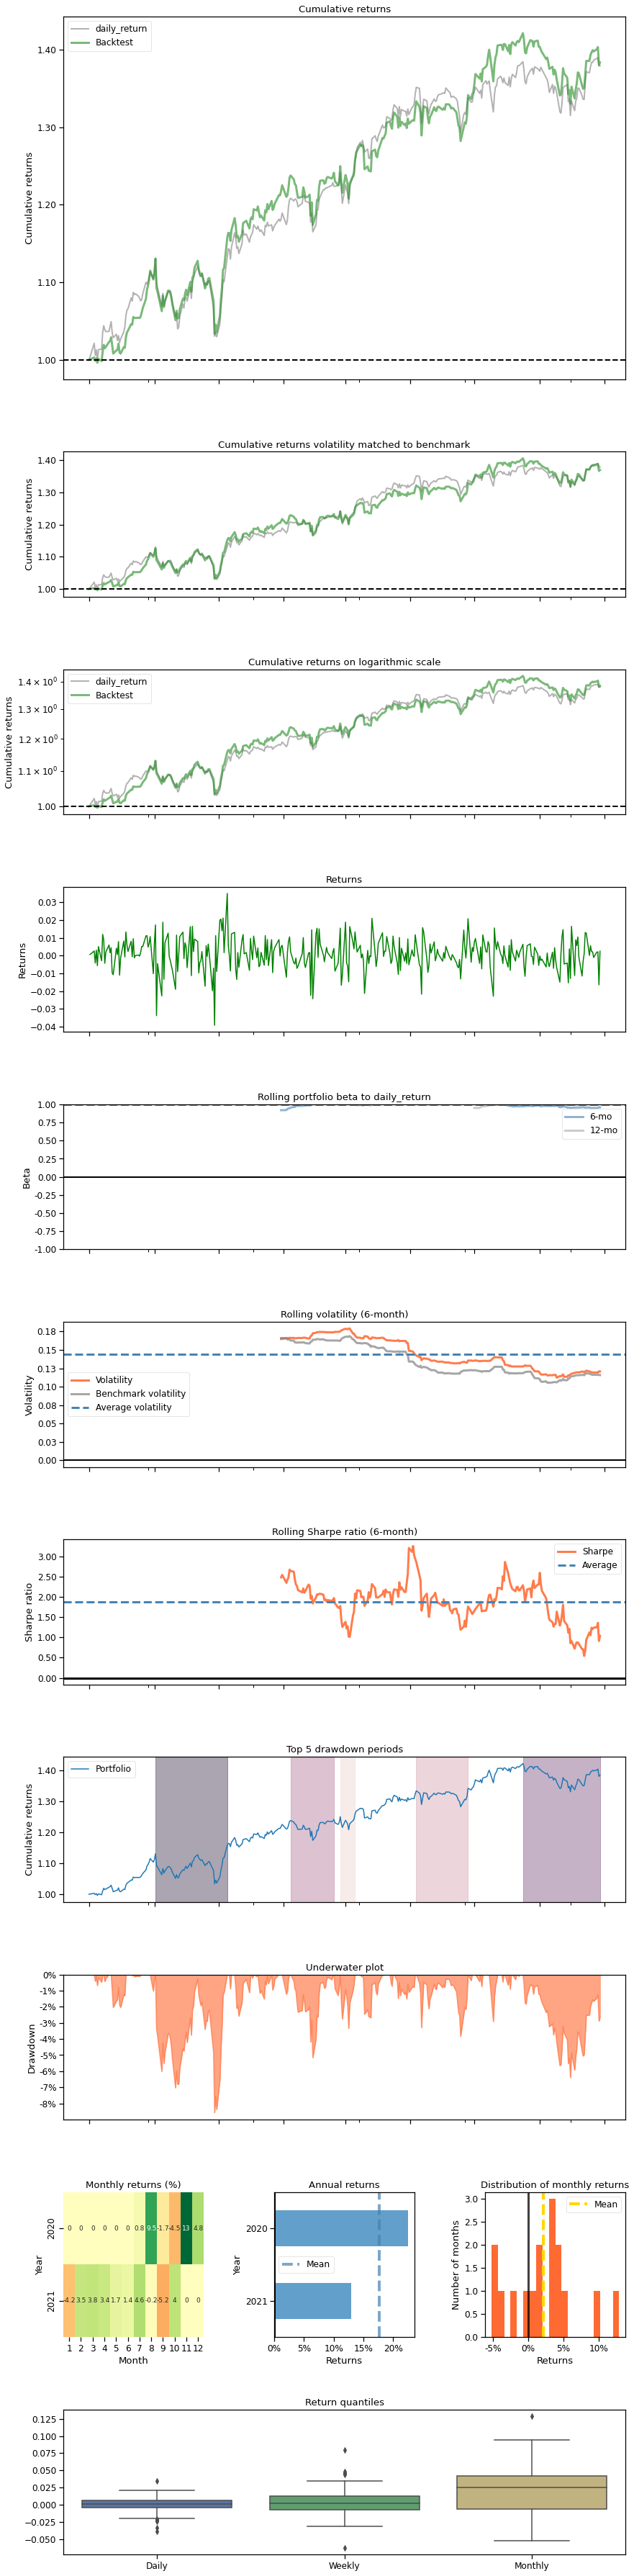

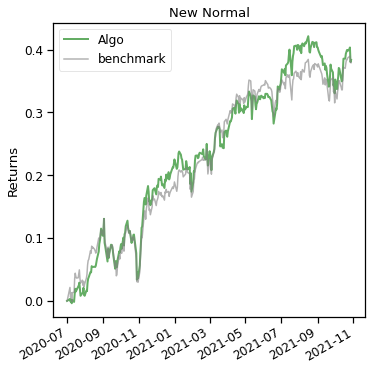

In [158]:
print("==============Compare to DJIA===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot(df_account_value, 
             baseline_ticker = '^DJI', 
             baseline_start = df_account_value.loc[0,'date'],
             baseline_end = df_account_value.loc[len(df_account_value)-1,'date'])

In [185]:
# df_account_value, df_actions = DRLAgent.DRL_prediction(
#     model=trained_sac, 
#     environment = e_trade_gym)
e_trade_gym2 = StockTradingEnv(df = trade, turbulence_threshold = 70,risk_indicator_col='vix', **env_kwargs)
df_account_value2, df_actions2 = DRLAgent.DRL_prediction(
    model=trained_ppo2, 
    environment = e_trade_gym)
df_account_value2

hit end!


,date,account_value
0,2020-07-01,1000000.0
1,2020-07-02,1000000.0
2,2020-07-06,1000000.0
3,2020-07-07,1000000.0
4,2020-07-08,1000000.0
...,...,...
331,2021-10-22,1000000.0
332,2021-10-25,1000000.0
333,2021-10-26,1000000.0
334,2021-10-27,1000000.0


==============Get Backtest Results===========
Annual return          0.0
Cumulative returns     0.0
Annual volatility      0.0
Sharpe ratio           NaN
Calmar ratio           NaN
Stability              0.0
Max drawdown           0.0
Omega ratio            NaN
Sortino ratio          NaN
Skew                   NaN
Kurtosis               NaN
Tail ratio             NaN
Daily value at risk    0.0
dtype: float64
==============Get Baseline Stats===========
Annual return          0.269722
Cumulative returns     0.374922
Annual volatility      0.139083
Sharpe ratio           1.792302
Calmar ratio           3.020136
Stability              0.919220
Max drawdown          -0.089308
Omega ratio            1.347571
Sortino ratio          2.655481
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.052781
Daily value at risk   -0.016534
dtype: float64
==============Compare to DJIA===========


/home/zj/anaconda3/envs/finrl/lib/python3.7/site-packages/empyrical/stats.py:713: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/home/zj/anaconda3/envs/finrl/lib/python3.7/site-packages/empyrical/stats.py:799: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
/home/zj/anaconda3/envs/finrl/lib/python3.7/site-packages/empyrical/stats.py:1528: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))
/home/zj/anaconda3/envs/finrl/lib/python3.7/site-packages/empyrical/stats.py:713: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/home/zj/anaconda3/envs/finrl/lib/python3.7/site-packages/empyrical/stats.py:799: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
/home/zj/anaconda3/envs/finrl/lib/python3.7/site-packages/empyrical/stats.py:1528: RuntimeWarning: inva

Start date,2020-07-01
End date,2021-10-28
Total months,16
,Backtest
Annual return,0.0%
Cumulative returns,0.0%
Annual volatility,0.0%
Sharpe ratio,NaN
Calmar ratio,NaN
Stability,0.00
Max drawdown,0.0%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,0.00,2020-07-01,2020-07-01,2020-07-01,1
1,NaN,NaT,NaT,NaT,NaN
2,NaN,NaT,NaT,NaT,NaN
3,NaN,NaT,NaT,NaT,NaN
4,NaN,NaT,NaT,NaT,NaN


Stress Events,mean,min,max
New Normal,0.00%,0.00%,0.00%


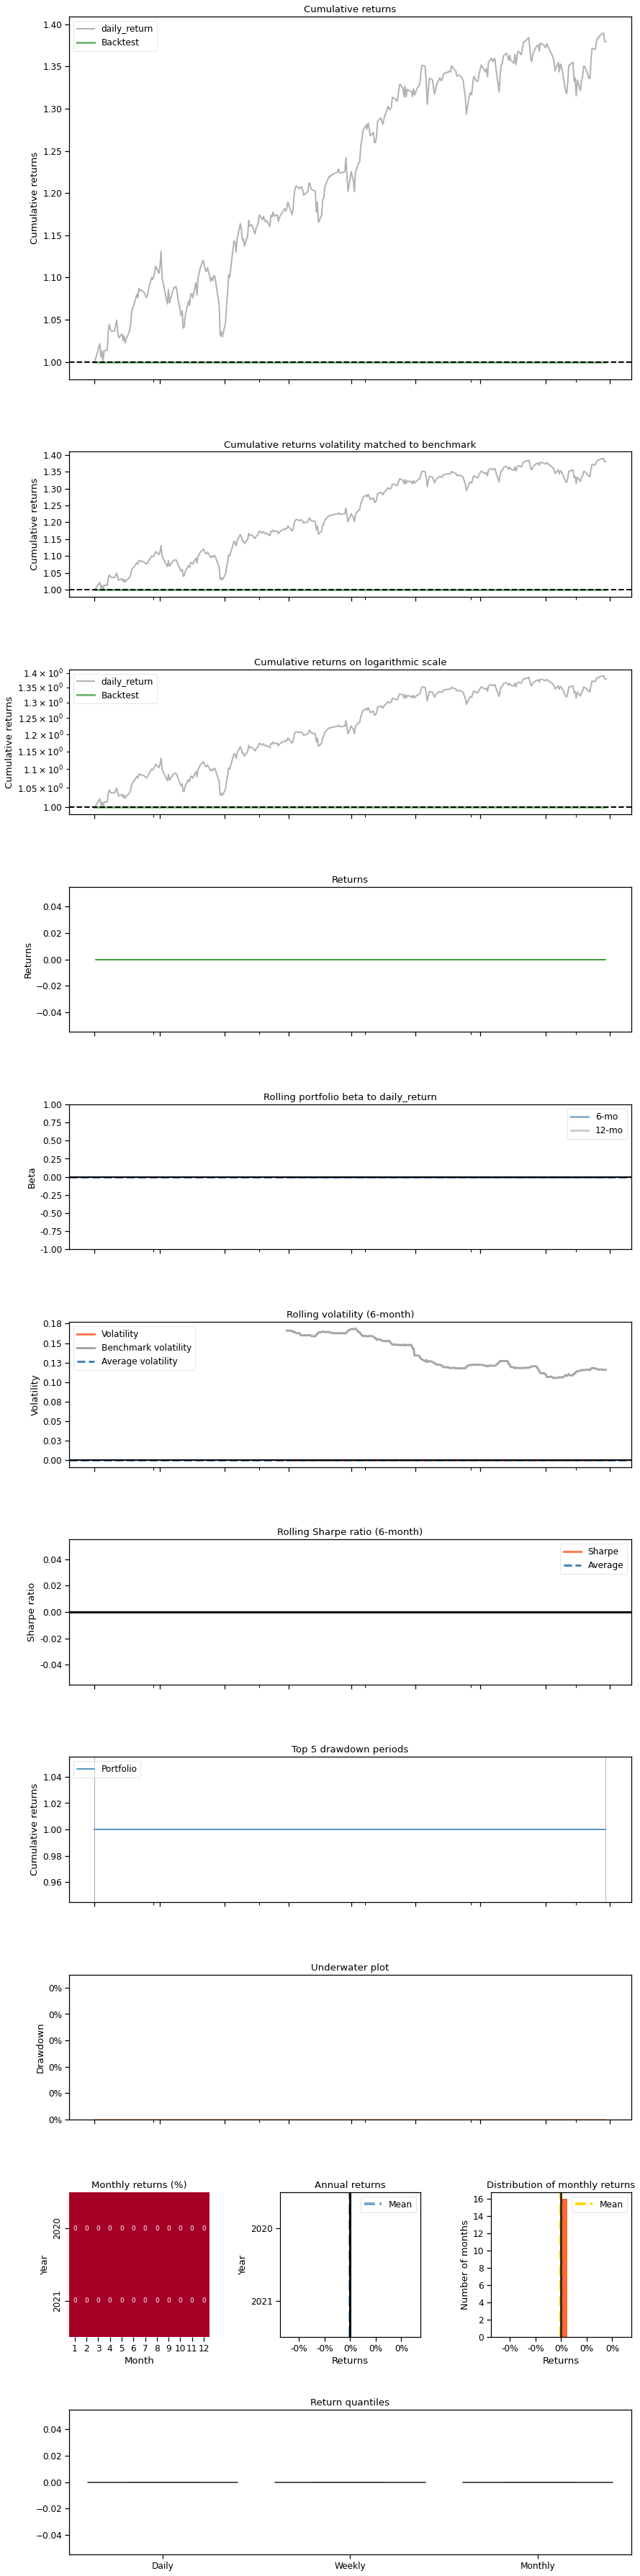

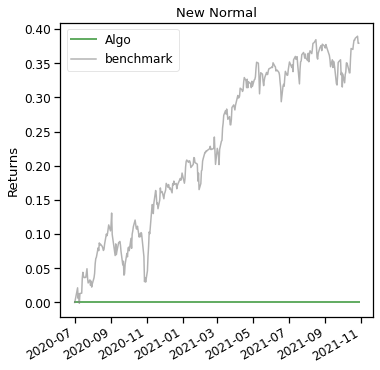

In [181]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value2)
perf_stats_all = pd.DataFrame(perf_stats_all)
perf_stats_all.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_"+now+'.csv')
#baseline stats
print("==============Get Baseline Stats===========")
baseline_df = get_baseline(
        ticker="^DJI", 
        start = df_account_value2.loc[0,'date'],
        end = df_account_value2.loc[len(df_account_value)-1,'date'])

stats = backtest_stats(baseline_df, value_col_name = 'close')
print("==============Compare to DJIA===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot(df_account_value2, 
             baseline_ticker = '^DJI', 
             baseline_start = df_account_value2.loc[0,'date'],
             baseline_end = df_account_value2.loc[len(df_account_value)-1,'date'])